## Problem Statement and Hypothesis:

SF rents have been steadily rising since 2000 to 2010 when 28,500 newcomers arrived to the city. From 2010-2012, 20,600 additional people moved in, in just three years. People have attributed the growth of population to the blazing technology sector. 

While the demand for housing increased, supply was relatiively fixed due to zoning laws. The most fundamental rule of economics dictates that prices rise when there is a high demand but low supply. I was interested in seeing how crime affects prices in certain neighbourhoods and if there was a relation between price and crime.

To complete this goal I analyzed trends of reported crime and rent hikes in different neighborhoods and reported trends with exploratory graphs. Predict prices of housing in San Francisco using districts, years, bedrooms, and aggregate crime counts per district per year. Use Regression, CART, Random Forests to predict rental prices based on variables such as categorized crime counts, bedrooms, and year. 

In [1]:
import pandas as pd
import numpy as np
import shapely

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Description of Data: 

The project involves an in depth analysis of the change of rental and crime rates in San Francisco from 2003-2015. Data was retrieved from a multitude of sources but mainly Eric Fischers github repo of aggregated Craigslist rental data archived from wayback machine and the SF crime data set from opendata.

Original data from craigslist appears as below, and I needed to parse and extract attributes specifically price, bedrooms, and district. This task was performed through a variety of data structure methods and regular expressions. The issue with craigslist data is that posts are inconsistent in structure and name of districts, to counter this problem I used scoring algorithms vs a dictionary of San Francisco districts to standardize my data.

![alttext](https://snag.gy/c6B3eQ.jpg)

## Variable Engineering:

Variables were obtained from the craigslist data and locations of districts were scraped from Google. The rest of the variables were present in the crime dataset. Engineered a few binary features based on whether a crime was violent, alcohol related, organized, narcotic, or city related.



In [3]:
#crime = pd.read_csv('./train.csv')    # read in crime
crime = pd.read_csv('./SFPD_Incidents_-_from_1_January_2003.csv')
crime_sub = crime.sample(100000)   #subset sample
crime_sub.head(1)


IncidntNum  Category        Descript DayOfWeek        Date   Time  \
1399038   101001884  WARRANTS  WARRANT ARREST  Thursday  10/28/2010  11:02   

        PdDistrict      Resolution              Address           X  \
1399038       PARK  ARREST, BOOKED  SCOTT ST / LLOYD ST -122.435054   

                 Y                               Location            PdId  
1399038  37.769897  (37.7698968941871, -122.435054154915)  10100188463010

In [2]:
district_coordinates = pd.read_csv('./district_coordinates.csv')   # read in coordinates
del district_coordinates['Unnamed: 0']
district_coordinates = district_coordinates.dropna()
district_coordinates.head()  # 4 coordinate places is an accuracy of 11 meters

district      lat       lon
0      bernal heights  37.7412 -122.4178
1              castro  37.7609 -122.4350
2           chinatown  37.7941 -122.4078
4           excelsior  37.7244 -122.4272
5  financial district  37.7946 -122.3999

In [131]:
crime_sub.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97203 entries, 2010-10-28 to 2014-02-03
Data columns (total 23 columns):
IncidntNum        97203 non-null int64
Category          97203 non-null object
Descript          97203 non-null object
DayOfWeek         97203 non-null object
Time              97203 non-null object
PdDistrict        97203 non-null object
Resolution        97203 non-null object
Address           97203 non-null object
X                 97203 non-null float64
Y                 97203 non-null float64
Location          97203 non-null object
PdId              97203 non-null int64
X1                97203 non-null float64
Y1                97203 non-null float64
match_district    97203 non-null object
is_theft          97203 non-null int64
is_drunk          97203 non-null int64
is_organized      97203 non-null int64
is_violent        97203 non-null int64
is_narcotic       97203 non-null int64
is_city           97203 non-null int64
year              97203 non-null int32

In [154]:
crime_sub.head()

IncidntNum       Category  \
Date                                    
2010-10-28   101001884       WARRANTS   
2006-01-05    60018714  LARCENY/THEFT   
2012-07-01   120517632          FRAUD   
2003-07-20    30862648        ASSAULT   
2012-09-21   126152252   NON-CRIMINAL   

                                           Descript DayOfWeek   Time  \
Date                                                                   
2010-10-28                           WARRANT ARREST  Thursday  11:02   
2006-01-05             GRAND THEFT FROM LOCKED AUTO  Thursday  18:10   
2012-07-01  FRAUDULENT USE OF AUTOMATED TELLER CARD    Sunday  10:00   
2003-07-20              INFLICT INJURY ON COHABITEE    Sunday  17:25   
2012-09-21                            LOST PROPERTY    Friday  18:00   

           PdDistrict      Resolution                             Address  \
Date                                                                        
2010-10-28       PARK  ARREST, BOOKED                 SCOTT ST / LLOYD ST   
2006-01-05    BAYVIEW            NONE             DEHARO ST / MARIPOSA ST   
2012-07-01       PARK            NONE                HAYES ST / PIERCE ST   
2003-07-20   NORTHERN  ARREST, BOOKED                  POLK ST / UNION ST   
2012-09-21   SOUTHERN            NONE  0 Block of THE EMBARCADEROSOUTH ST   

                     X          Y    ...             Y1    match_district  \
Date                                 ...                                    
2010-10-28 -122.435054  37.769897    ...      37.769897      lower haight   
2006-01-05 -122.401481  37.763562    ...      37.763562      potrero hill   
2012-07-01 -122.434485  37.775417    ...      37.775417  western addition   
2003-07-20 -122.422340  37.798761    ...      37.798761      russian hill   
2012-09-21 -122.388380  37.783310    ...      37.783310       south beach   

            is_theft  is_drunk is_organized  is_violent  is_narcotic  is_city  \
Date                                                                            
2010-10-28         0         0            0           0            0        0   
2006-01-05         1         0            0           0            0        0   
2012-07-01         0         0            0           0            0        0   
2003-07-20         0         0            0           1            0        0   
2012-09-21         0         0            0           0            0        0   

            year       Date  
Date                         
2010-10-28  2010 2010-10-28  
2006-01-05  2006 2006-01-05  
2012-07-01  2012 2012-07-01  
2003-07-20  2003 2003-07-20  
2012-09-21  2012 2012-09-21  

[5 rows x 23 columns]

In [155]:
posts_crimes.head()

D1_ARSON  D1_ASSAULT  D1_BAD CHECKS  D1_BRIBERY  D1_BURGLARY  \
0         0           9              0           0            4   
1         0           7              0           0            5   
2         1          37              1           0           10   
3         1          16              0           0           12   
4         1          12              0           0            6   

   D1_DISORDERLY CONDUCT  D1_DRIVING UNDER THE INFLUENCE  D1_DRUG/NARCOTIC  \
0                      1                               0                 1   
1                      0                               1                 1   
2                      4                               1                34   
3                      2                               0                 3   
4                      0                               0                 4   

   D1_DRUNKENNESS  D1_EMBEZZLEMENT       ...        bed        district1  \
0               0                1       ...          1           sunset   
1               2                0       ...          2           marina   
2               1                2       ...          2     hayes valley   
3               1                0       ...          0  pacific heights   
4               1                0       ...          1   inner richmond   

          district2          district3  \
0          parkside       inner sunset   
1          nob hill           nob hill   
2        noe valley  visitacion valley   
3  presidio heights     inner richmond   
4    outer richmond       inner sunset   

                                                post   price  year  \
0  950  1br  sunny one bedroom for rent sunset  p...   950.0  2003   
1  1500  2br  1 ba cow hollow open house thursday...  1500.0  2003   
2  1795  2br  spacious  completely remodeled 2 bd...  1795.0  2003   
3  1180  0br  victorian hotel room wprivate bath ...  1180.0  2003   
4  1100  1br  great landlordgreat tenats inner ri...  1100.0  2003   

   district1_code  district2_code  district3_code  
0              45              36              14  
1              21              27              27  
2              11              28              51  
3              33              40              13  
4              13              32              14  

[5 rows x 124 columns]

### Exploratory Data Aanlysis:

Below are a series of several plots that annotate crime per year for all of sf, median price per year for all of sf, crime/price for districts I thought would represent the most possible neighborhoods and population of San Francisco. Finally there is a series of plots of crimes of interest from the engineered dummy variables based on whether a crime was violent, alcohol related, organized, narcotic, or city related.

![alt text](https://snag.gy/drov4h.jpg)

![alt text](https://snag.gy/iueFGt.jpg)

![alt text](https://snag.gy/JhSIeD.jpg)

![alt text](https://snag.gy/FBvsql.jpg)

![alt text](https://snag.gy/VBGKnm.jpg)

![alt text](https://snag.gy/MaqYbw.jpg)

![alt text](https://snag.gy/sme2St.jpg)

![alt text](https://snag.gy/qd04hF.jpg)

![alt text](https://snag.gy/ul3FW8.jpg)

![alt text](https://snag.gy/R9aHBN.jpg)

LARCENY/THEFT     19684
OTHER OFFENSES    13846
NON-CRIMINAL      10166
ASSAULT            8310
VEHICLE THEFT      5946
DRUG/NARCOTIC      5940
VANDALISM          4935
WARRANTS           4694
BURGLARY           4063
SUSPICIOUS OCC     3404
Name: Category, dtype: int64


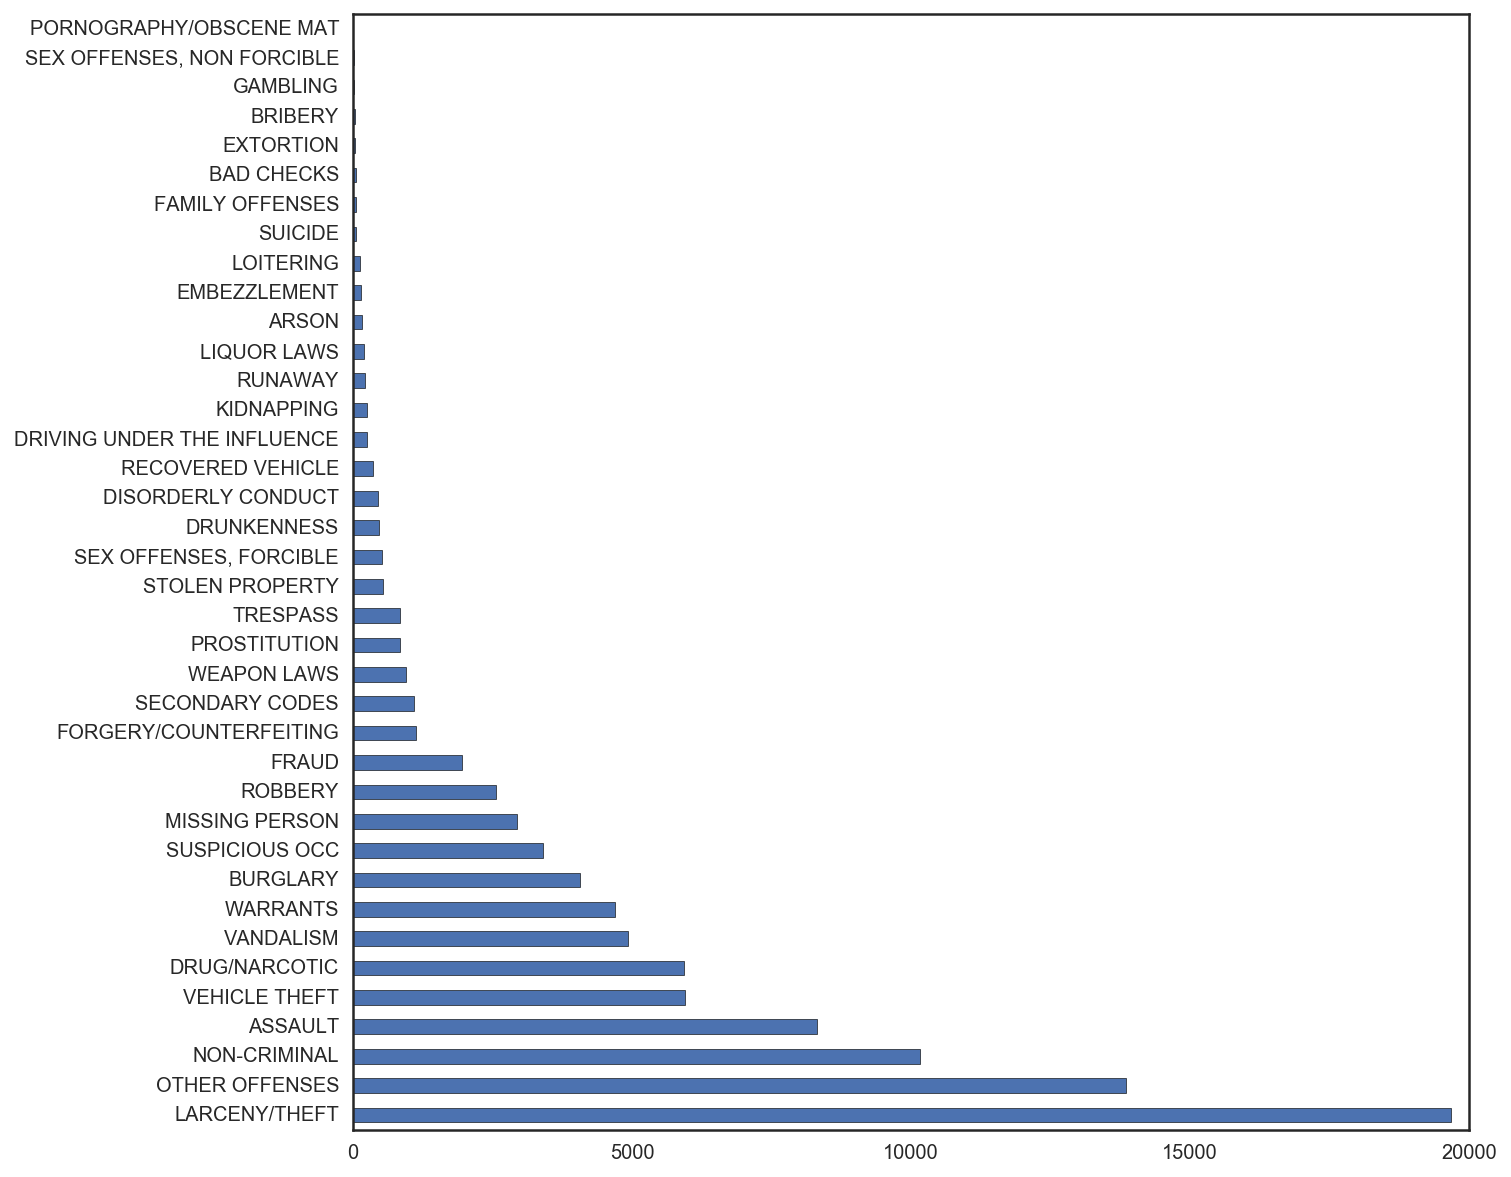

In [121]:
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_style('white')


print crime_sub.Category.value_counts()[0:10]
crime_sub.Category.value_counts().plot(kind = 'barh')

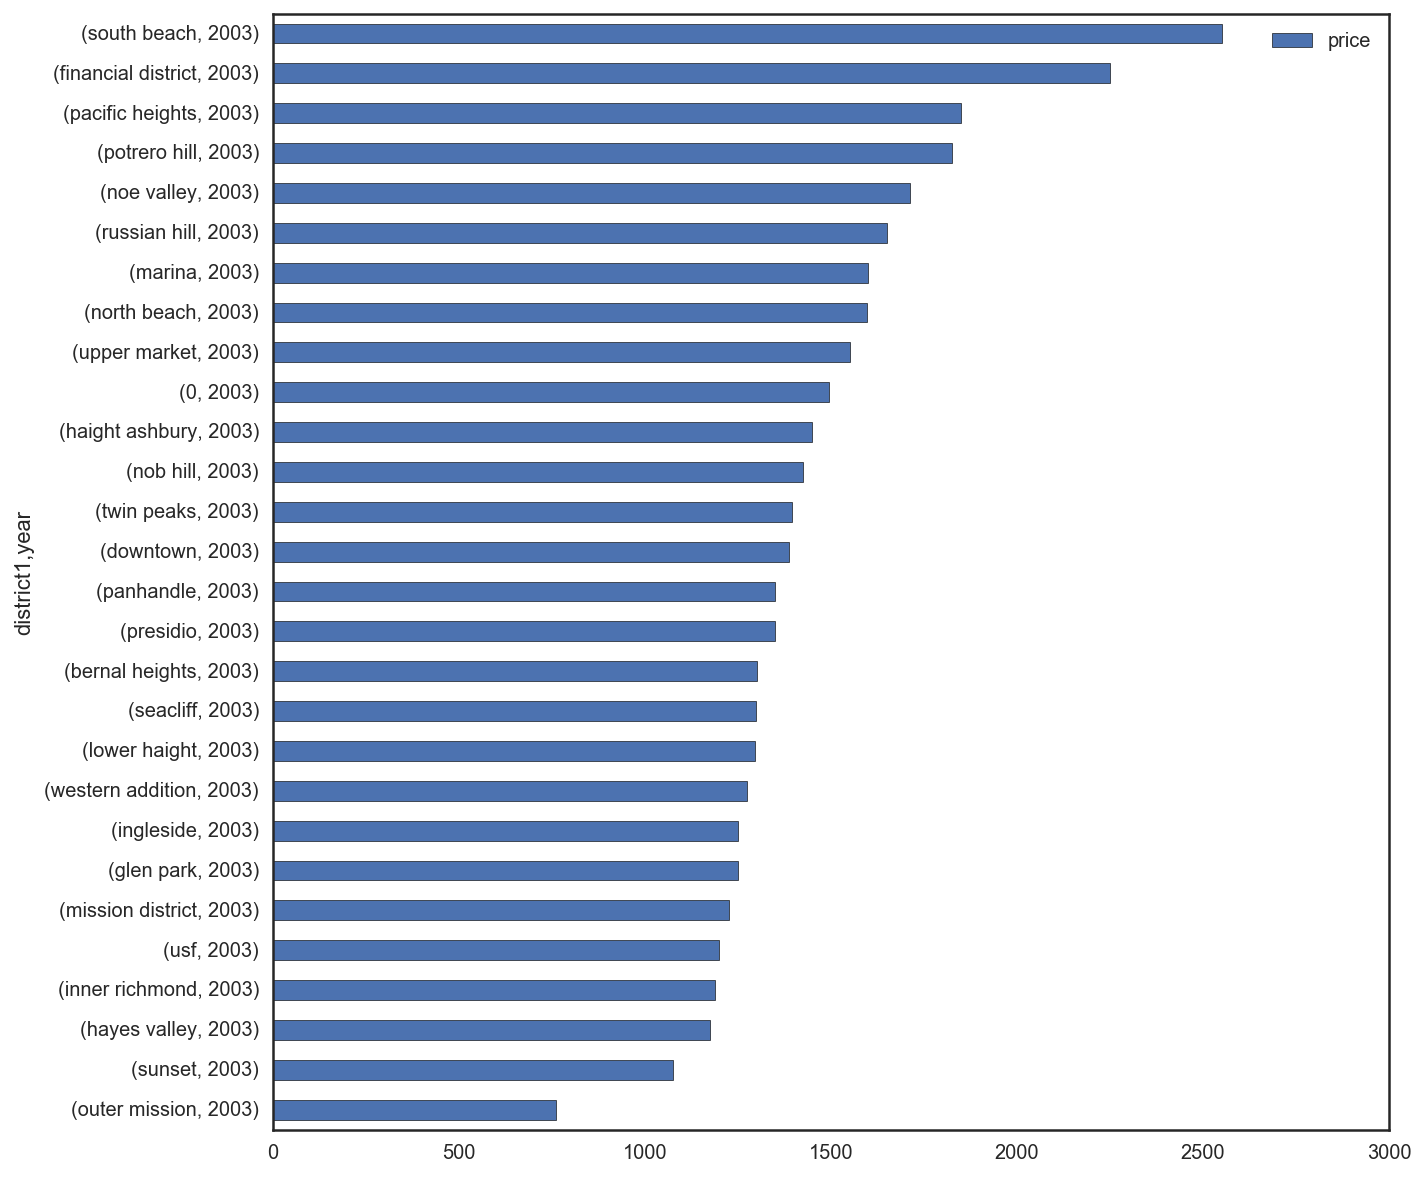

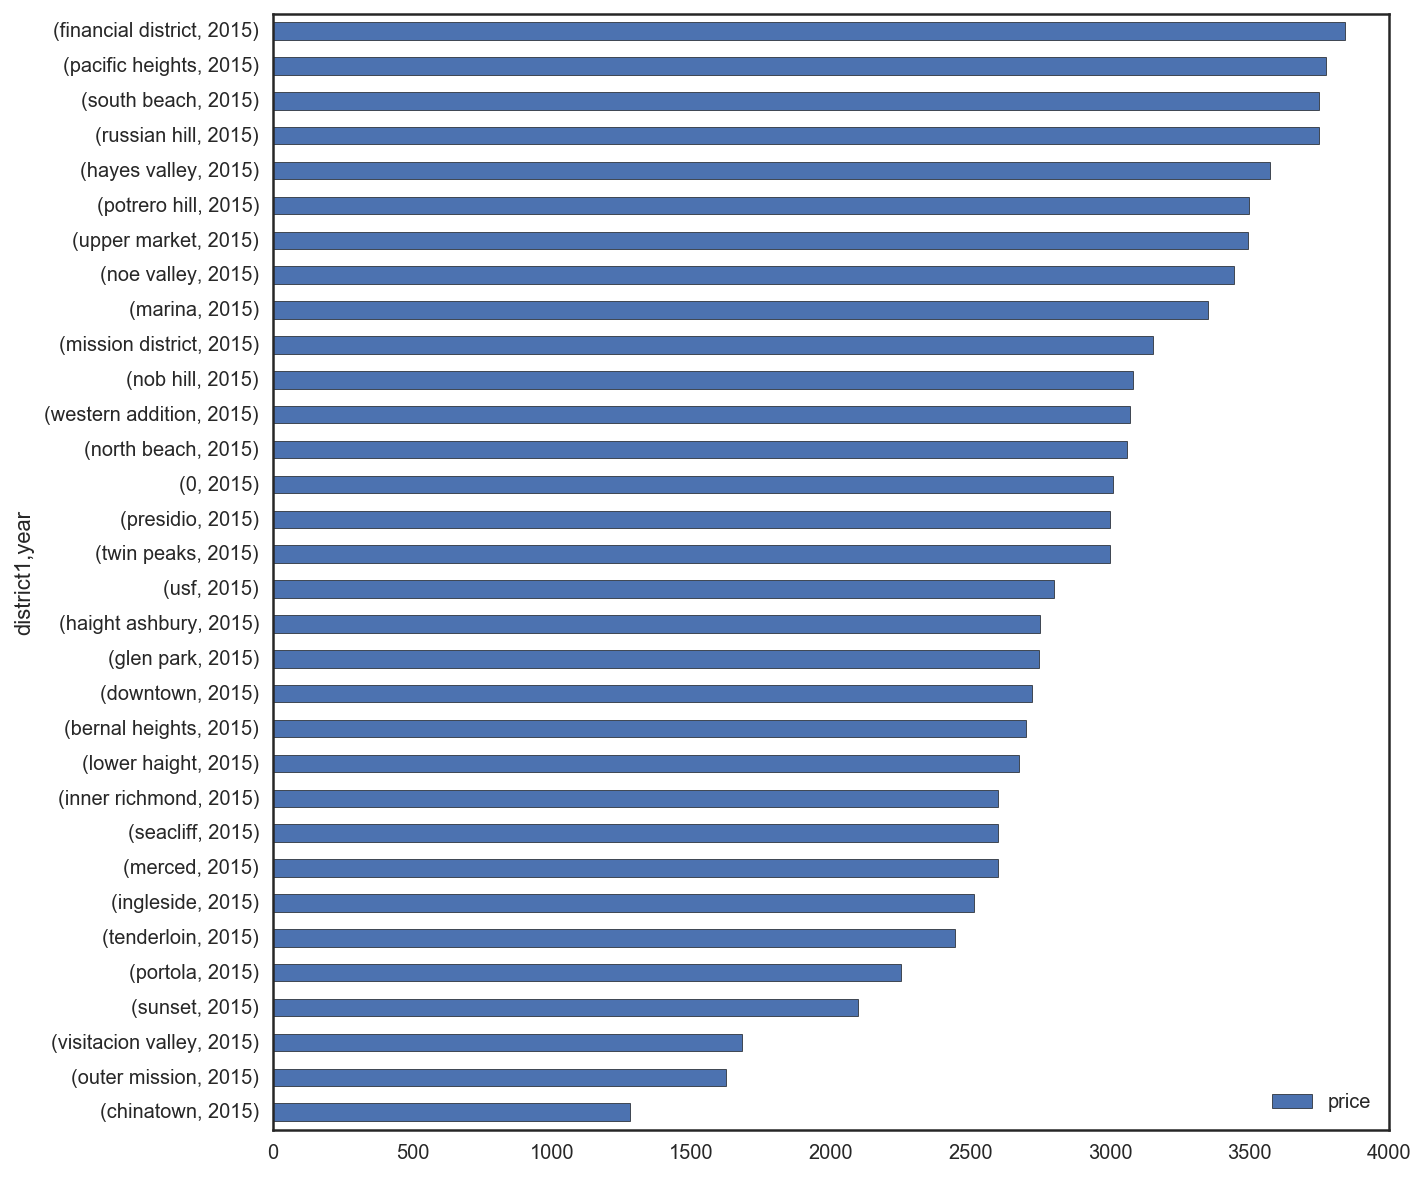

In [122]:
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_style('white')

price_by_hood_pre = posts_crimes[posts_crimes.bed == 1]
price_by_hood = pd.DataFrame(price_by_hood_pre.groupby(['district1','year']).median()['price']).reset_index()

price_by_hood[price_by_hood.year == (2003)].groupby(['district1','year']).median().sort_values('price').plot(kind = 'barh')

price_by_hood[price_by_hood.year == (2015)].groupby(['district1','year']).median().sort_values('price').plot(kind = 'barh')

# Function to map crime location coordinates to districts

The crime dataset had different districts of SanFrancisco (Police Districts) than the craigslist data districts. This created a problem since there were no common columns to perform a merge on. To solve this issue I scraped coordinates for each craigslist district center and wrote a function that calculates the closest distance to the crime location coordinates. The function uses the haversine distance as a scoring metric creating a list of scores from each district to the crime location, the distance that is the lowest is assumbed to be the district that the crime is in.

In [4]:
# get decimals as a feature X1 X2 from the location coordinates
from decimal import Decimal
def replace_lon(location):
    
    lon = str(location).replace('(','').replace(')','').split(',')
    lon = np.float64(lon[1])
    return lon
    
def replace_lat(location):
    lat = str(location).replace('(','').replace(')','').split(',')
    lat = np.float64(lat[0])
    return lat
    
crime_sub['X1'] = crime_sub.apply(lambda row: replace_lon(row['Location']),axis = 1)
crime_sub['Y1'] = crime_sub.apply(lambda row: replace_lat(row['Location']),axis = 1)

# haversine distances to check which crime occured in what district
%timeit
from haversine import haversine
def check_distance(location):
    #print location
    haversine_list = []
    for d,lat,lon in zip(district_coordinates.district,district_coordinates.lat, district_coordinates.lon):

        haversine_list.append((haversine(location, (lon,lat)),d))
    
    match = sorted(haversine_list)[0][1]
    return match
    
crime_sub['match_district'] = crime_sub.apply(lambda row: check_distance((row['X1'],row['Y1'])), axis = 1 )

Create sub crime categories based on crimes that could be considered under the same category.

In [5]:
# create crime Categories
crime_sub.Category.value_counts()

theft = ['LARCENY/THEFT','VEHICLE THEFT','BURGLARY','ROBBERY','STOLEN PROPERTY','RECOVERED VEHICLE']
drunk = ['DRUG/NARCOTIC','DRUNKENNESS','LIQOUR LAWS','DRIVING UNDER THE INFLUENCE','LIQUOR LAWS']
organized = ['BRIBERY','EXTORTION','PROSTITUTION']
violent = ['ASSAULT','SEX OFFENSES, FORCIBLE','KIDNAPPING']
narcotic = ['DRUG/NARCOTIC']
city = ['VANDALISM','LOITERING']

crime_sub['is_theft'] = crime_sub.Category.apply(lambda x: 1 if x in theft else 0)
crime_sub['is_drunk'] = crime_sub.Category.apply(lambda x: 1 if x in drunk else 0)
crime_sub['is_organized'] = crime_sub.Category.apply(lambda x: 1 if x in organized else 0)
crime_sub['is_violent'] = crime_sub.Category.apply(lambda x: 1 if x in violent else 0)
crime_sub['is_narcotic'] = crime_sub.Category.apply(lambda x: 1 if x in narcotic else 0)
crime_sub['is_city'] = crime_sub.Category.apply(lambda x: 1 if x in city else 0)

## Convert indexes and dates to datetime:

Use pandas date time to convert date column into the index, then use that information to create a yearly feature for the crimes.

In [6]:
from datetime import datetime as dt
print crime_sub.index.dtype
crime_sub['Date'] = pd.to_datetime(crime_sub['Date'])
crime_sub.set_index('Date',inplace= True)
print crime_sub.index.dtype

# create a year function, 2016 is not completely represented
crime_sub['year'] = crime_sub.index.map(lambda val: val.year)
crime_sub.head(1)
crime_sub = crime_sub[crime_sub['year'] < 2016]

int64
datetime64[ns]


In [7]:
posts = pd.read_csv('./craigslist_posts.csv')
posts.head()
posts = posts[posts.bed < 6]

## Transformations: 
Use a series of transformations to merge the data from 2 separate data frames of craigslists posts and crimes to aggregate counts of crime categories per district per year and the rental listing information.

In [8]:
crime_groups = pd.DataFrame(crime_sub.groupby(['year','Category','match_district']).size())

crime_wide = crime_groups.reset_index()
crime_wide.head()

crime_wide.columns = ['year','crime','district','crime_count']
crime_wide.head()

print [x for x in crime_wide.district.values if not type(x) == str]

crime_wide = crime_wide[[True if type(x) == str else False for x in crime_wide.district.values]]

crime_wide.district = crime_wide.district.map(lambda x: x.lower())
crime_wide_ = pd.pivot_table(crime_wide, index=['year','crime'], columns=['district'], fill_value=0)['crime_count'].reset_index()
crime_wide_.head()

crime_trans = crime_wide.T

posts = posts.iloc[:,1:]
posts.head()

crime_trans.columns = np.ravel(crime_trans.ix['crime',:].values)
crime_trans.head()

small_posts = posts

small_posts.shape

small_posts.year.value_counts()

[]


2005    15455
2004     6433
2006     4529
2016     2494
2012     2283
2014     2218
2015     2030
2011     1476
2007      884
2013      772
2003      497
2008      487
2009      195
2010       99
Name: year, dtype: int64

In [ ]:
# Transformations to aggregate counts

new_dfs = []

for i, row in small_posts.iterrows():
    
    ndf = pd.DataFrame({
            'post':[row.post],
            'year':[row.year],
            'price':[row.price],
            'bed':[row.bed],
            'district1':[row.district1],
            'district2':[row.district2],
            'district3':[row.district3]
        })
    ndf.index = [i]
    
    d1_mask_colmask = (crime_trans.loc['year',:] == row.year) & (crime_trans.loc['district',:] == row.district1)
    d2_mask_colmask = (crime_trans.loc['year',:] == row.year) & (crime_trans.loc['district',:] == row.district2)
    d3_mask_colmask = (crime_trans.loc['year',:] == row.year) & (crime_trans.loc['district',:] == row.district3)
    
    district1_crimes = crime_trans.ix[['crime_count'], d1_mask_colmask]
    district2_crimes = crime_trans.ix[['crime_count'], d2_mask_colmask]
    district3_crimes = crime_trans.ix[['crime_count'], d3_mask_colmask]
    
    district1_crimes.columns = ['D1_'+x for x in district1_crimes.columns]
    district2_crimes.columns = ['D2_'+x for x in district2_crimes.columns]
    district3_crimes.columns = ['D3_'+x for x in district3_crimes.columns]
    
    dist_crimes = pd.concat([district1_crimes, district2_crimes, district3_crimes],
                            axis=1, ignore_index=False)
    
    
    dist_crimes.index = [i]
    
    ndf = pd.concat([ndf, dist_crimes], axis=1, ignore_index=False)
    
    new_dfs.append(ndf)
    
posts_crimes = pd.concat(new_dfs, axis=0, ignore_index=False).fillna(value=0, axis=1)
    
    
    
    

In [ ]:
posts_crimes.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder

posts_crimes.district1 = posts_crimes.district1.map(lambda x: 'none' if x == 0 else x)
posts_crimes.district2 = posts_crimes.district2.map(lambda x: 'none' if x == 0 else x)
posts_crimes.district3 = posts_crimes.district3.map(lambda x: 'none' if x == 0 else x)

label_encoder = LabelEncoder()

dists = posts_crimes.district1.values.tolist() + posts_crimes.district2.values.tolist() + posts_crimes.district3.values.tolist()
dists = np.unique(dists)
# print dists
# print posts_crimes.district1.unique()
# print posts_crimes.district2.unique()
# print posts_crimes.district3.unique()


label_encoder.fit(dists)

posts_crimes['district1_code'] = label_encoder.transform(posts_crimes.district1.values)
posts_crimes['district2_code'] = label_encoder.transform(posts_crimes.district2.values)
posts_crimes['district3_code'] = label_encoder.transform(posts_crimes.district3.values)

In [ ]:

posts_crimes.to_csv('./aggregate_df.csv')

In [132]:
posts_crimes = pd.read_csv('./aggregate_df.csv')
del posts_crimes['Unnamed: 0']

In [133]:
posts_crimes.head(1)

D1_ARSON  D1_ASSAULT  D1_BAD CHECKS  D1_BRIBERY  D1_BURGLARY  \
0         0           9              0           0            4   

   D1_DISORDERLY CONDUCT  D1_DRIVING UNDER THE INFLUENCE  D1_DRUG/NARCOTIC  \
0                      1                               0                 1   

   D1_DRUNKENNESS  D1_EMBEZZLEMENT       ...        bed  district1  district2  \
0               0                1       ...          1     sunset   parkside   

      district3                                               post  price  \
0  inner sunset  950  1br  sunny one bedroom for rent sunset  p...  950.0   

   year  district1_code  district2_code  district3_code  
0  2003              45              36              14  

[1 rows x 124 columns]

In [134]:
posts_crimes = posts_crimes[posts_crimes.price < 50000]

In [135]:
target = posts_crimes.price
tmp = posts_crimes[[col for col in posts_crimes if posts_crimes[col].dtype != object or col == 'district1']]

print posts_crimes.post.dtype

object


In [136]:
tmp.head()

D1_ARSON  D1_ASSAULT  D1_BAD CHECKS  D1_BRIBERY  D1_BURGLARY  \
0         0           9              0           0            4   
1         0           7              0           0            5   
2         1          37              1           0           10   
3         1          16              0           0           12   
4         1          12              0           0            6   

   D1_DISORDERLY CONDUCT  D1_DRIVING UNDER THE INFLUENCE  D1_DRUG/NARCOTIC  \
0                      1                               0                 1   
1                      0                               1                 1   
2                      4                               1                34   
3                      2                               0                 3   
4                      0                               0                 4   

   D1_DRUNKENNESS  D1_EMBEZZLEMENT       ...        D3_VEHICLE THEFT  \
0               0                1       ...                      17   
1               2                0       ...                       0   
2               1                2       ...                      57   
3               1                0       ...                      24   
4               1                0       ...                      17   

   D3_WARRANTS  D3_WEAPON LAWS  bed        district1   price  year  \
0            0               1    1           sunset   950.0  2003   
1            0               0    2           marina  1500.0  2003   
2           22               6    2     hayes valley  1795.0  2003   
3            7               0    0  pacific heights  1180.0  2003   
4            0               1    1   inner richmond  1100.0  2003   

   district1_code  district2_code  district3_code  
0              45              36              14  
1              21              27              27  
2              11              28              51  
3              33              40              13  
4              13              32              14  

[5 rows x 121 columns]

In [137]:
bigml = [c for c in tmp if 'D1' in c ]+['bed','year','district1_code','district1','price']
bigml = tmp[bigml]
bigml.to_csv('bigml.csv')

In [138]:
#pd.read_csv('./bigml.csv')

In [139]:
D1 = [c for c in tmp if 'D1' in c ]+['bed','year','district1_code']
tmp[D1].head()

D1_ARSON  D1_ASSAULT  D1_BAD CHECKS  D1_BRIBERY  D1_BURGLARY  \
0         0           9              0           0            4   
1         0           7              0           0            5   
2         1          37              1           0           10   
3         1          16              0           0           12   
4         1          12              0           0            6   

   D1_DISORDERLY CONDUCT  D1_DRIVING UNDER THE INFLUENCE  D1_DRUG/NARCOTIC  \
0                      1                               0                 1   
1                      0                               1                 1   
2                      4                               1                34   
3                      2                               0                 3   
4                      0                               0                 4   

   D1_DRUNKENNESS  D1_EMBEZZLEMENT       ...        D1_SUICIDE  \
0               0                1       ...                 0   
1               2                0       ...                 0   
2               1                2       ...                 0   
3               1                0       ...                 0   
4               1                0       ...                 1   

   D1_SUSPICIOUS OCC  D1_TRESPASS  D1_VANDALISM  D1_VEHICLE THEFT  \
0                  4            0            13                 7   
1                  1            0             7                13   
2                  9            8            21                37   
3                  4            2             7                18   
4                  9            3             5                24   

   D1_WARRANTS  D1_WEAPON LAWS  bed  year  district1_code  
0            1               1    1  2003              45  
1            1               1    2  2003              21  
2           30               3    2  2003              11  
3            0               0    0  2003              33  
4            7               0    1  2003              13  

[5 rows x 41 columns]

In [140]:
district_codes_df = tmp[D1]['district1_code']

In [141]:
district_codes_df.head()

0    45
1    21
2    11
3    33
4    13
Name: district1_code, dtype: int64

## Model Selection:

The goal of this analysis was to use the types of crime  40 categories, # of bedrooms, years and the district code as a numerical variable to predict the price of rent. To accomplish this I first used linear-regression and performed an r^2 value of .43. As a result of having so many different features 40 crime categories, year price I felt that using a decision tree with cross validation of train test split and sample splits of 2,5,10 would perform better. I used grid search to find the best DecisionTreeRegressor (.57) and a depth of 9. Next I used feature importances to select for the highest performers and ran the best model decision tree on only the seected features and it performed at .60 with the most important features being bed year district and larceny. Next I ran random forests and the score improved to .62 with the selected features.

In [149]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

X = tmp[D1]
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

lm = LinearRegression()

model = lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)
print model.score(X_test, y_test)   # coefficient of r2
print model.score(X_test,y_pred)


0.455895185182
1.0


In [150]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(tmp[D1], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


param_grid = {'max_depth': np.arange(3, 10),'min_samples_split':[2,5,10]}

tree = GridSearchCV(DecisionTreeRegressor(criterion='mse'), param_grid, cv = 10,n_jobs = -1)

tree.fit(X_train, y_train)

tree_preds = tree.predict(X_test)
print X_test.shape,y_test.shape


tree_performance = tree.score(X_test, y_test)

print tree_preds
print tree_performance
print tree.best_params_
print tree.grid_scores_
print tree.best_estimator_
print tree.best_score_


(13143, 41) (13143,)
[ 1603.94230769  1274.03778338  2067.10958904 ...,  2013.09161793
  1806.70878274  2189.43556701]
0.573459294574
{'min_samples_split': 2, 'max_depth': 9}
[mean: 0.39309, std: 0.02225, params: {'min_samples_split': 2, 'max_depth': 3}, mean: 0.39309, std: 0.02225, params: {'min_samples_split': 5, 'max_depth': 3}, mean: 0.39309, std: 0.02225, params: {'min_samples_split': 10, 'max_depth': 3}, mean: 0.42304, std: 0.02635, params: {'min_samples_split': 2, 'max_depth': 4}, mean: 0.42304, std: 0.02635, params: {'min_samples_split': 5, 'max_depth': 4}, mean: 0.42304, std: 0.02635, params: {'min_samples_split': 10, 'max_depth': 4}, mean: 0.47444, std: 0.03590, params: {'min_samples_split': 2, 'max_depth': 5}, mean: 0.47444, std: 0.03590, params: {'min_samples_split': 5, 'max_depth': 5}, mean: 0.47444, std: 0.03590, params: {'min_samples_split': 10, 'max_depth': 5}, mean: 0.51637, std: 0.04423, params: {'min_samples_split': 2, 'max_depth': 6}, mean: 0.51587, std: 0.04329, pa

(13143, 41) (13143,)
[ 1696.94495413  1149.96159122  2052.98426745 ...,  1480.02469136
  4054.64285714  2281.22155689]
performance r2: 0.580719889268
[  2.04996391e-05   2.25524899e-02   5.72851345e-06   1.60984497e-04
   4.84608756e-03   2.16567898e-04   6.04747672e-04   1.81078571e-02
   3.82280014e-04   1.11331887e-04   1.63530988e-04   3.15323147e-04
   1.32751768e-04   7.46055853e-04   0.00000000e+00   0.00000000e+00
   9.44086129e-02   1.11448899e-03   6.02381927e-05   3.89807586e-02
   5.17583784e-03   8.66237166e-03   0.00000000e+00   1.79853255e-04
   9.09357705e-04   2.33767588e-03   7.75982631e-04   5.13641614e-03
   8.01989893e-04   7.69576040e-05   3.35363190e-04   0.00000000e+00
   5.15675458e-03   2.66605829e-03   2.93904668e-03   8.24517110e-03
   4.71566463e-03   8.25894119e-05   4.00477619e-01   2.99707413e-01
   6.86875422e-02]


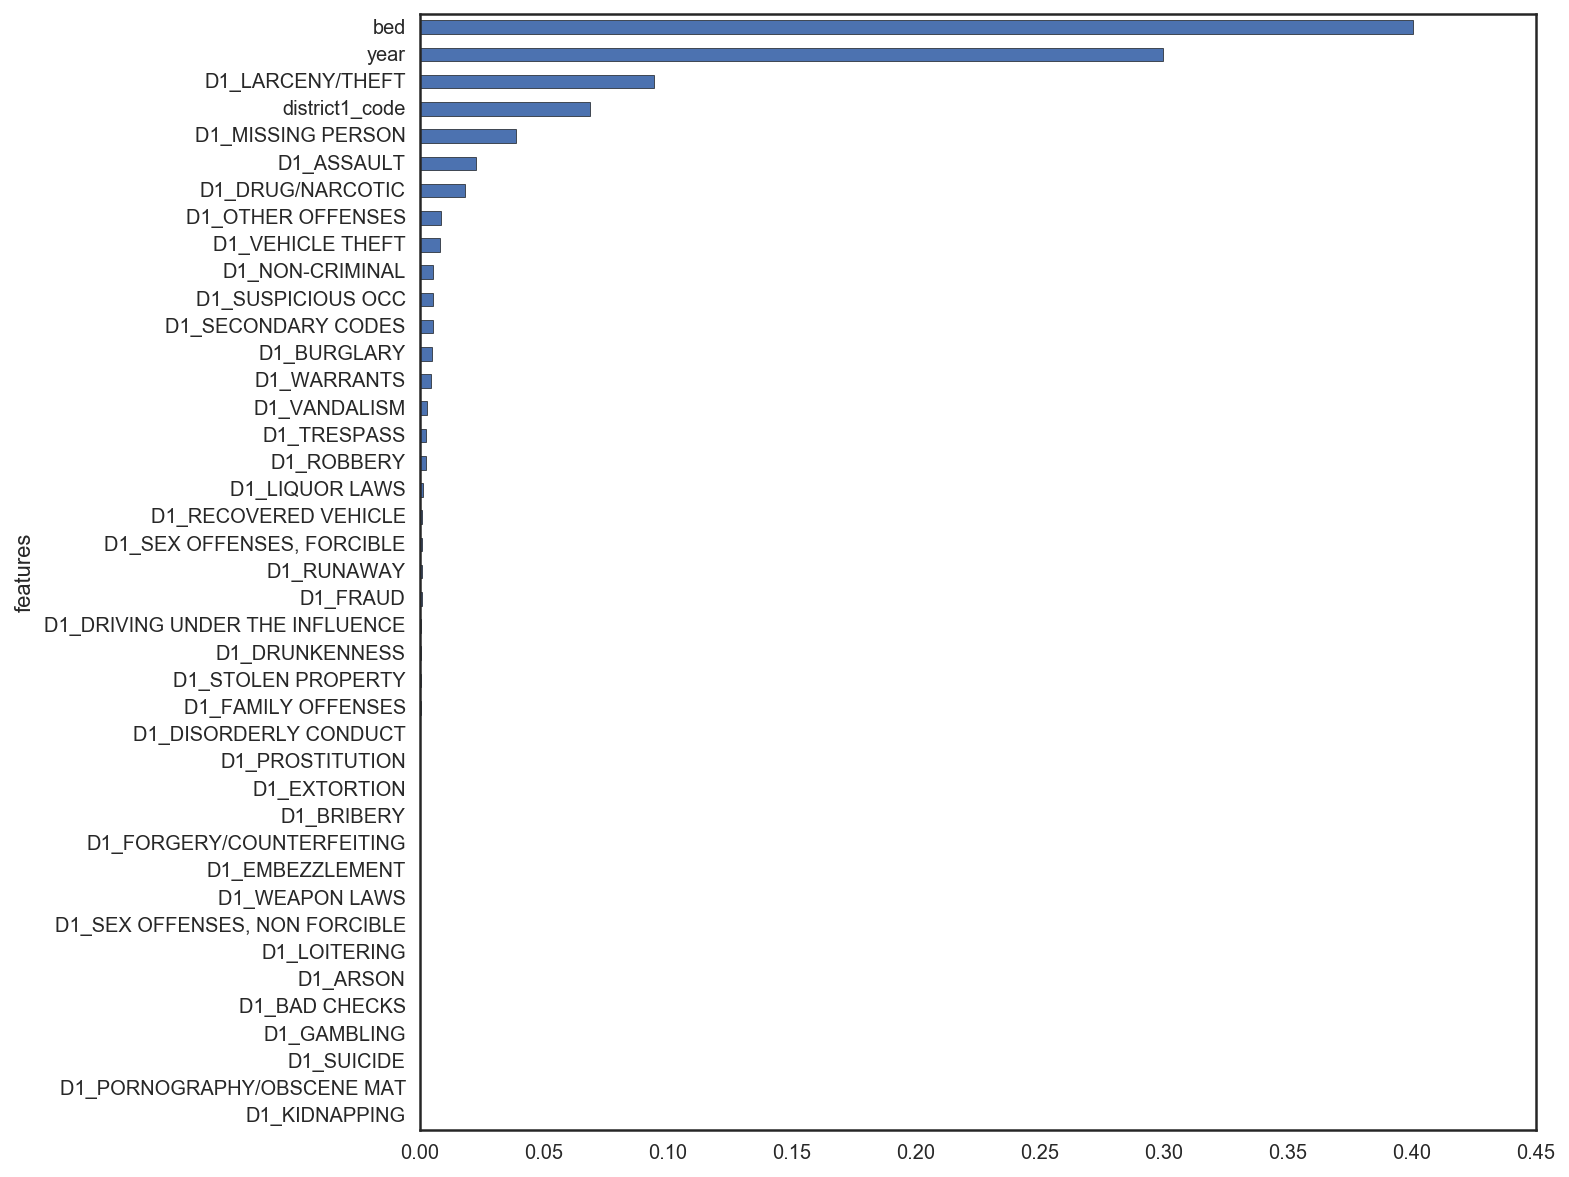

In [151]:

# best fit tree regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(tmp[D1], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

tree = DecisionTreeRegressor(criterion='mse', max_depth = 9, min_samples_split = 5)

tree.fit(X_train, y_train)

tree_preds = tree.predict(X_test)
print X_test.shape,y_test.shape


tree_performance = tree.score(X_test, y_test)

print tree_preds
print 'performance r2:',tree_performance
print tree.feature_importances_

features_df = pd.DataFrame([col for col in tmp[D1]],[i for i in tree.feature_importances_]).reset_index()

sns.set(rc={"figure.figsize": (10,10)})
sns.set_style('white')
features_df.rename(columns = {'index':'score',0:'features'},inplace = True)

features_df.set_index('features').score.sort_values().plot(kind = 'barh')

# 'year','bed','weapon laws',

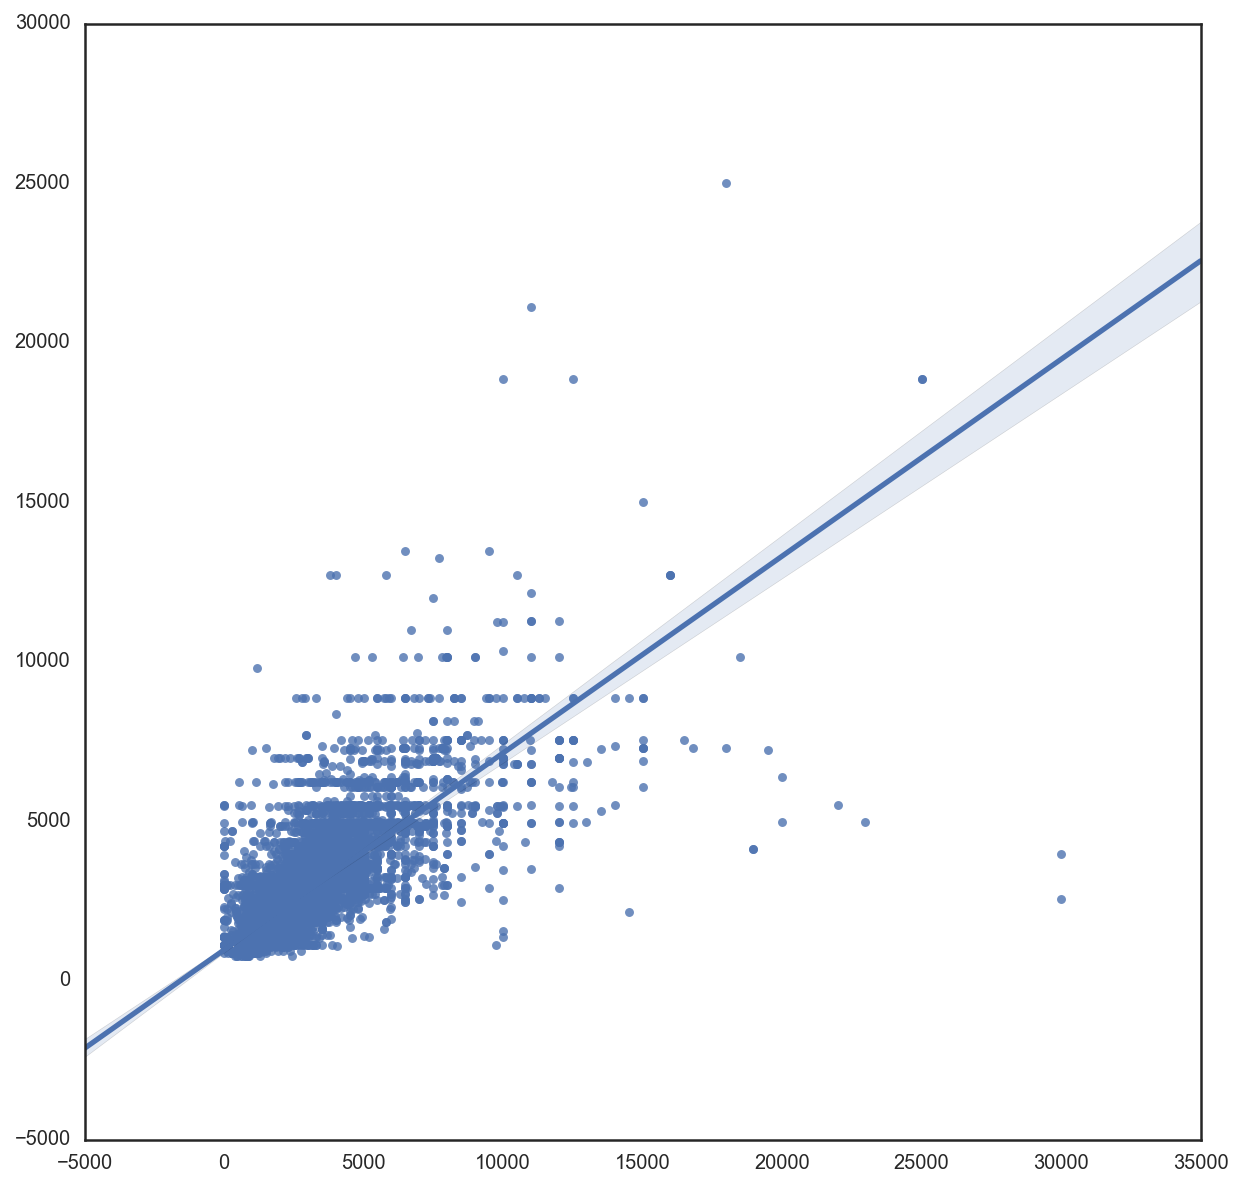

In [58]:
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_style('white')
sns.regplot(y_test,tree_preds)

In [152]:
selected_features = [i for i in features_df[features_df.score > .01].features]

# best fit tree regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(tmp[D1][selected_features], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

tree = DecisionTreeRegressor(criterion='mse', max_depth = 9, min_samples_split = 5)

tree.fit(X_train, y_train)

tree_preds = tree.predict(X_test)
print X_test.shape,y_test.shape

print target[0:3]
tree_performance = tree.score(X_test, y_test)

print tree_preds
print 'performance r2:',tree_performance
print tree.feature_importances_

#eatures_df = pd.DataFrame([col for col in tmp[D1]],[i for i in tree.feature_importances_]).reset_index()

(13143, 7) (13143,)
0     950.0
1    1500.0
2    1795.0
Name: price, dtype: float64
[ 3785.69117647  4729.39002268  1802.14620939 ...,  1443.95833333
  1627.39379475  2592.77777778]
performance r2: 0.600801665065
[ 0.03932828  0.02173101  0.10407693  0.04684223  0.40231574  0.30341123
  0.08229458]


## Random Forest

In [153]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

forest = RandomForestRegressor(random_state=0, n_estimators=1000, min_samples_split = 5)



X_train, X_test, y_train, y_test = train_test_split(tmp[D1], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

forest.fit(X_train, y_train)

forest_preds = forest.predict(X_test)

# forest_preds = cross_val_score(estimator = forest, X_test, y= y_test, scoring=None, cv=5, n_jobs=-1, verbose=0, fit_params=None)

forest_performance = forest.score(X_test, y_test)

print forest_preds
print 'forest r2:',forest_performance
print forest
print forest.get_params

[ 2798.00801042  1455.01134417  2529.72549368 ...,  2506.23580086
  1360.07531667   977.14651236]
forest r2: 0.57764370193
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
<bound method RandomForestRegressor.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)>


performance 0.574853421998


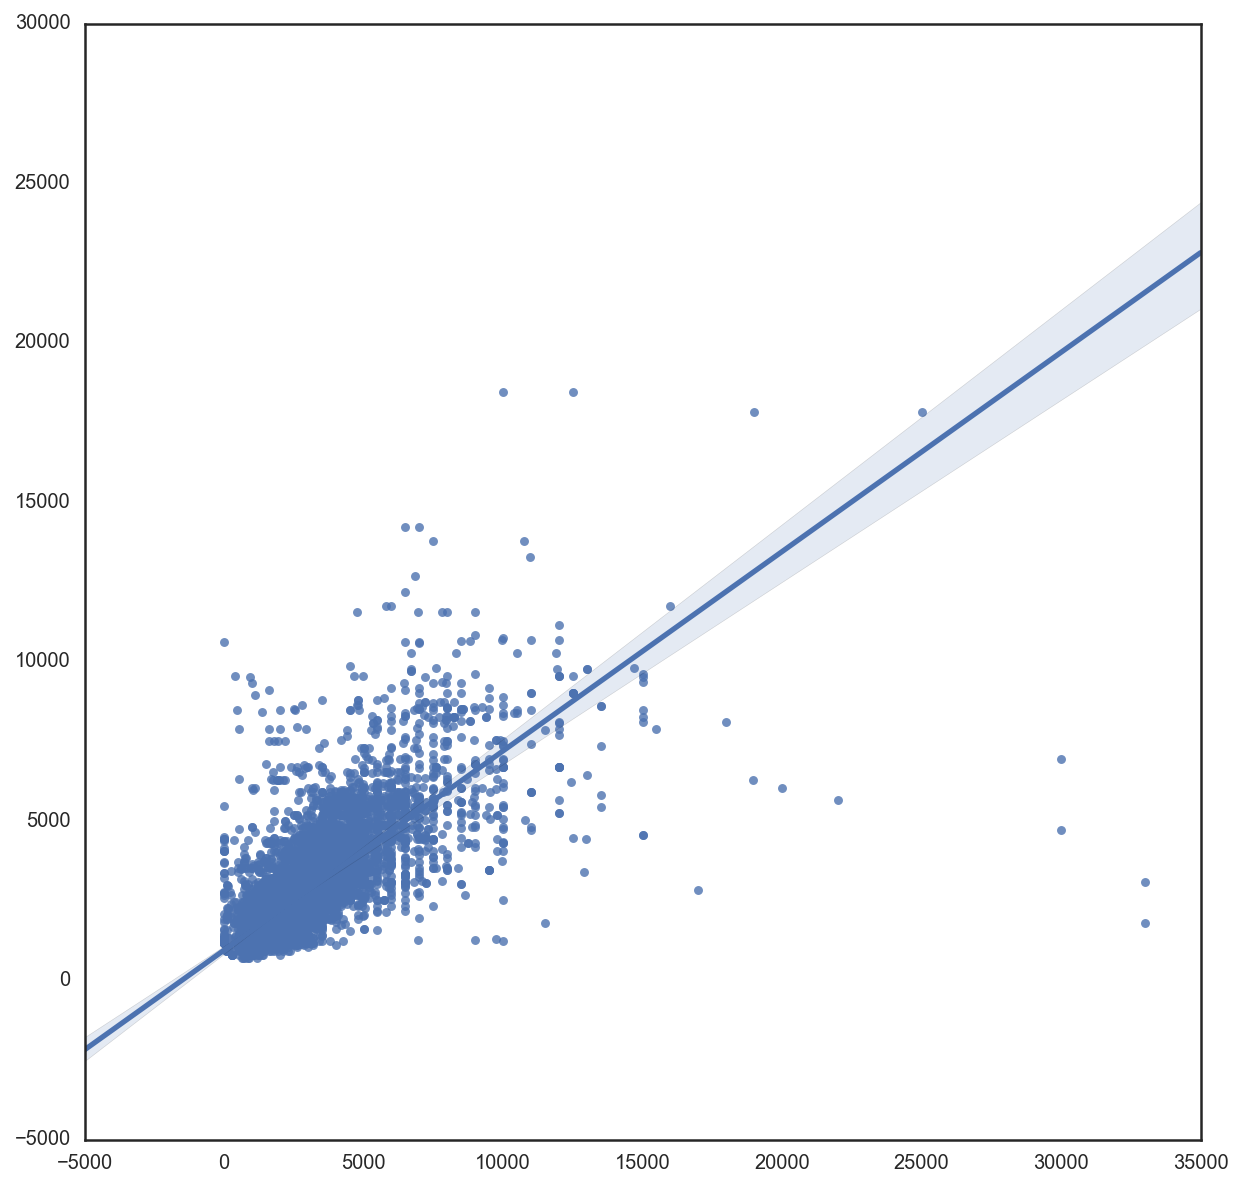

In [63]:
print 'performance', forest_performance
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_style('white')
sns.regplot(y_test,forest_preds)

In [64]:
# random forest selected features

# random forest selected features
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

forest = RandomForestRegressor(random_state=0, n_estimators=1000, min_samples_split = 5)



X_train, X_test, y_train, y_test = train_test_split(tmp[D1][selected_features], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

forest.fit(X_train, y_train)

forest_preds = forest.predict(X_test)

# forest_preds = cross_val_score(estimator = forest, X_test, y= y_test, scoring=None, cv=5, n_jobs=-1, verbose=0, fit_params=None)

forest_performance = forest.score(X_test, y_test)

print forest_preds
print 'forest r2:',forest_performance
print forest
print forest.get_params

[ 2634.46229774  2274.59509883  1991.6478776  ...,  3963.92108756
  9349.0070456   1616.4868673 ]
forest r2: 0.620942969865
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
<bound method RandomForestRegressor.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)>


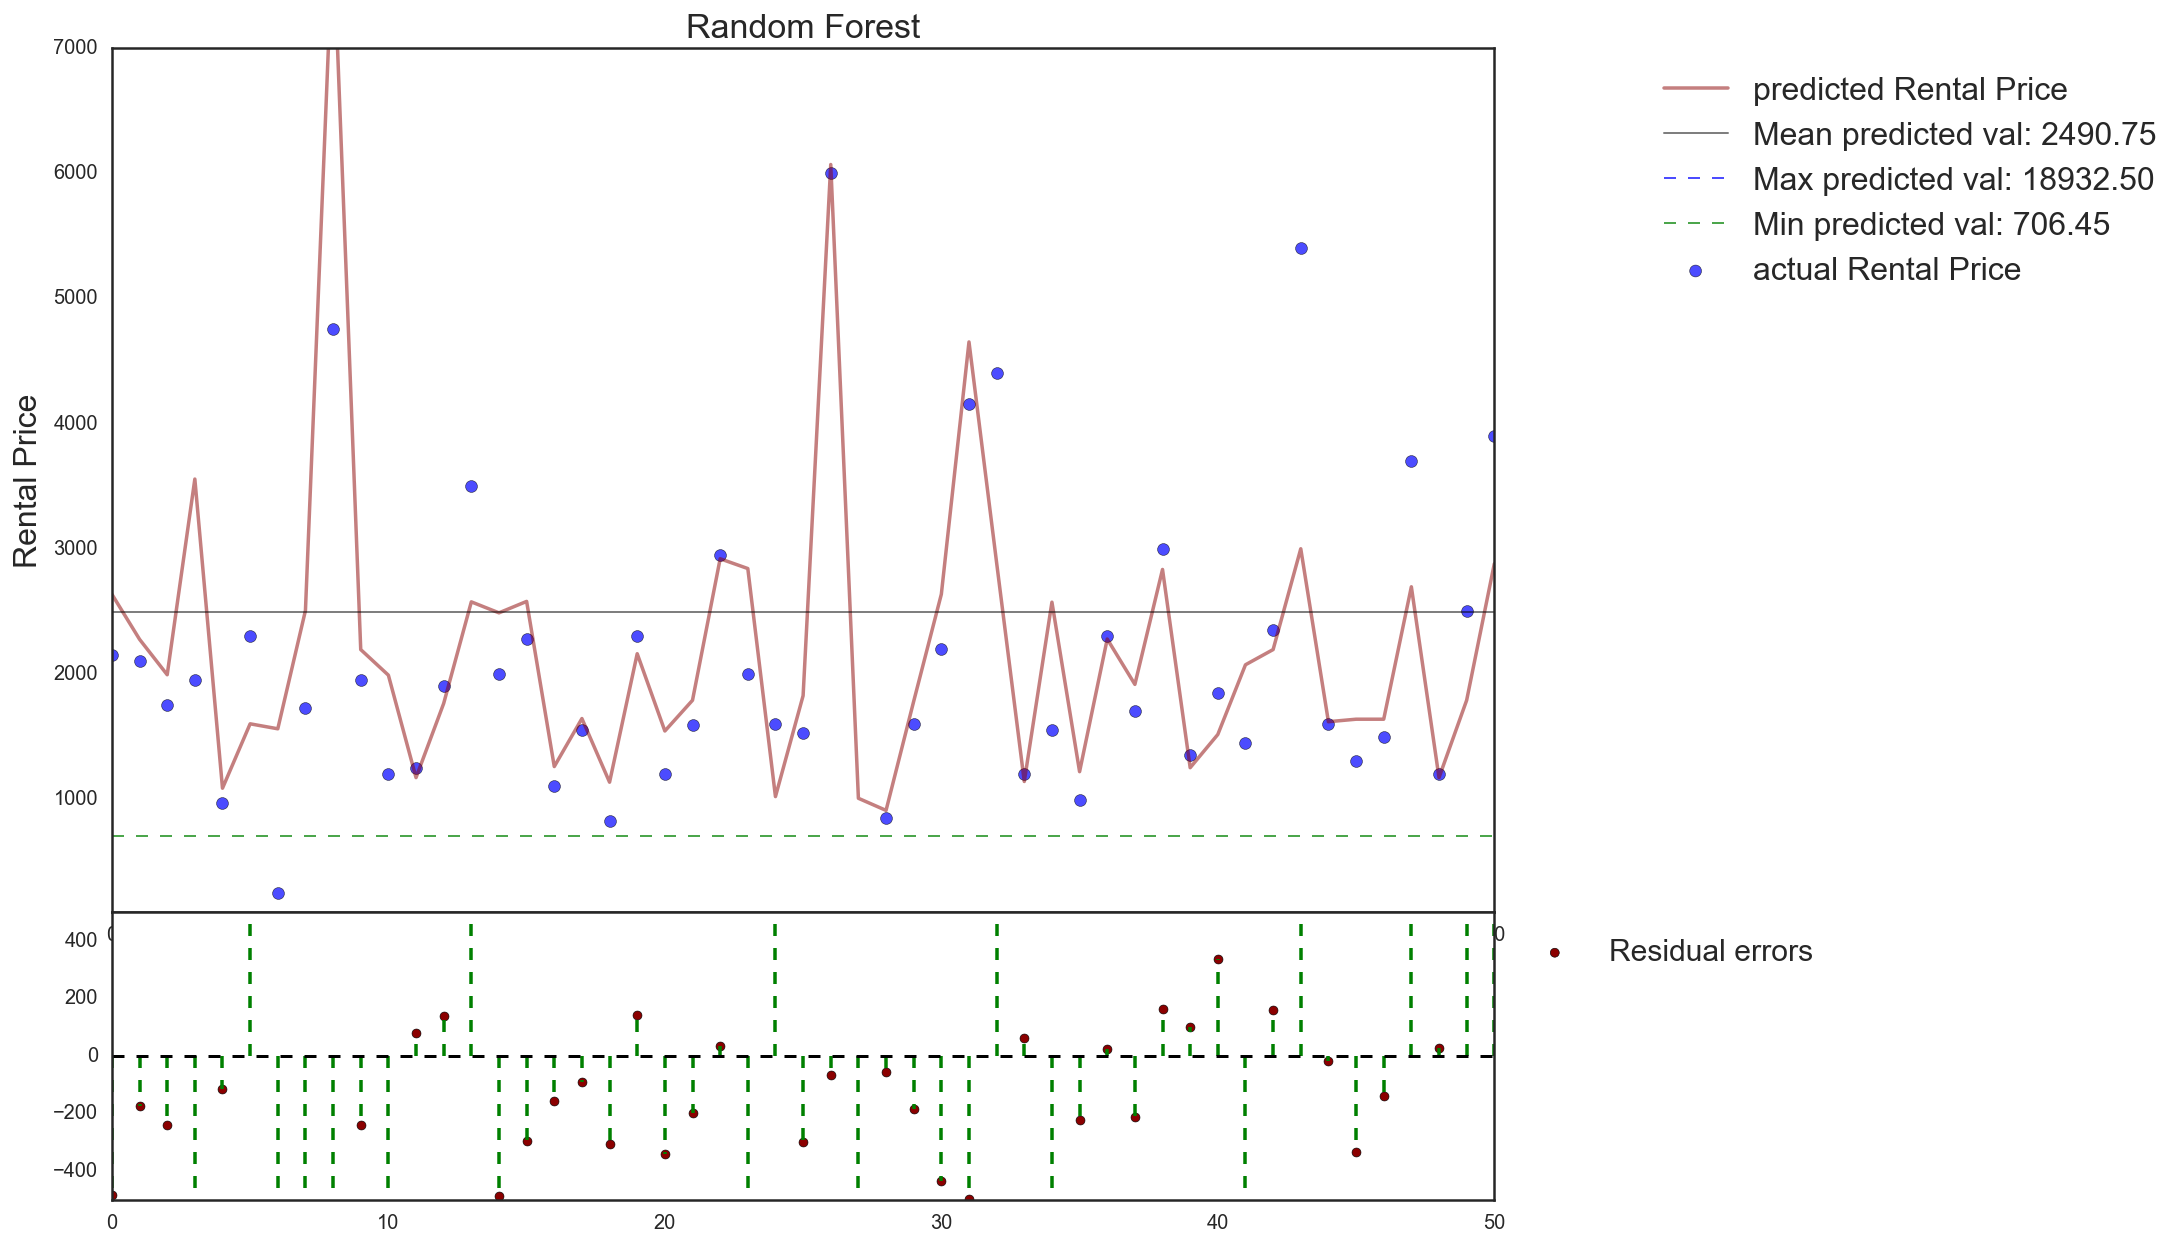

In [72]:
def prediction_plot(pred_array, title, x_limit, actual):
    fig = plt.figure(figsize=(12,10))
    
    frame1=fig.add_axes((.1,.3,.8,.6))
    
    mean_ = np.mean(pred_array)
    min_ = np.min(pred_array)
    max_ = np.max(pred_array)
    ax = fig.gca()
    
    ax.plot(range(len(pred_array)), pred_array, 
               alpha=0.5, c='darkred', label='predicted Rental Price')
    
    ax.scatter(range(len(actual)), actual, s=35,
               alpha=0.7, c='blue', label='actual Rental Price')
    
    zero = ax.axhline(0, lw=1.5, c='black')
    
    mean_line = ax.axhline(mean_, ls='-', lw=1., c='black', alpha=0.5,
                     label='Mean predicted val: %0.2f'%mean_)
              
    max_line = ax.axhline(max_, ls='--', lw=1., c='blue',alpha=0.7, 
               label='Max predicted val: %0.2f'%max_)
    min_line = ax.axhline(min_, ls='--', lw=1., c='green',alpha=0.7,
              label='Min predicted val: %0.2f'%min_)
    
    ax.legend(fontsize=16, bbox_to_anchor=(1.5,1.))
    ax.set_xlim([0,x_limit])
    ax.set_ylim([100,7000])
    ax.set_ylabel('Rental Price', fontsize=16)
    ax.set_title(title, fontsize=17)
    
    #Residual plot box
    residual_error = actual - pred_array
    residual_error = residual_error.tolist()
    
    frame2=fig.add_axes((.1,.1,.8,.2))
    frame2.scatter(range(len(residual_error)), residual_error, c='darkred', label='Residual errors')
    
    
    for i in range(len(residual_error)):
        frame2.plot((i,i),(0,residual_error[i]), ls='--', c='green')
    
    frame2.axhline(0, lw=1.5, c='black', ls='--')
    frame2.set_ylim([-500,500])
    frame2.set_xlim([0,x_limit])
    frame2.legend(bbox_to_anchor=(1.25,1.0), fontsize=15)
    plt.show()
    
    
def plot_list(plot_funtion ,lists, titles, x_limit, actual):
    for i,a in enumerate(lists):
        plot_funtion(a,titles[i], x_limit, actual)
        
plot_list(prediction_plot,[forest_preds], ['Random Forest'], 50, y_test)


### Random forest for each district and scores

In [156]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
features = {}

tmp = posts_crimes[[col for col in posts_crimes if posts_crimes[col].dtype != object or col == 'district1']]
D1 = [c for c in tmp if 'D1' in c ]+['bed','year','district1','price']
group_forest_df = tmp[D1]

for district, group_df in tmp[D1].groupby("district1"):
    try: 
        
        target = group_df.price
        predictors = group_df[[col for col in group_df if col not in ['price','district1']]]


        X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.33)


        y_train = np.ravel(y_train)
        y_test = np.ravel(y_test)

        model = RandomForestRegressor()

        forest = model.fit(X_train, y_train)
        forest_performance = model.score(X_test, y_test)
        print district, forest_performance
        features[district] = forest.feature_importances_
        
    except:
        continue

0 0.4534026884
bernal heights 0.669536523388
castro -0.432123693863
chinatown 0.0
downtown 0.525188033295
excelsior -2.0503125
financial district 0.180485130237
glen park 0.762569529916
golden gate park 0.0038805721573
haight ashbury 0.809309542235
hayes valley 0.667443686363
ingleside 0.615445378753
inner richmond 0.713054895864
lakeshore -32.935475
lone mountain 0.505649765158
lower haight 0.818314085141
marina 0.753731939664
merced 0.116390353074
mission bay 0.819564733915
mission district 0.692517015357
nob hill 0.527521115059
noe valley 0.756407496379
north beach 0.511068043108
oceanview -0.0545609254282
outer mission 0.719535573327
outer richmond -1.28764172336
pacific heights 0.696433784448
panhandle -2.17870662571
parkside 0.201585818162
portola 0.84213957272
potrero hill 0.728205741709
presidio 0.468807806929
presidio heights 0.742877588801
russian hill 0.379193824493
seacliff 0.651312352943
south beach 0.35067550601
south of market 0.258286039219
sunset 0.630659937749
tenderl

In [127]:
features_df = pd.DataFrame(features).T

In [128]:
features_df.columns = [i for i in predictors.columns]
features_df = features_df.T

In [129]:
features_df.head()

0  bernal heights    castro  chinatown  downtown  excelsior  \
D1_ARSON       0.0        0.001166  0.000000        0.0       0.0        0.0   
D1_ASSAULT     0.0        0.001177  0.000000        0.0       0.0        0.0   
D1_BAD CHECKS  0.0        0.000052  0.000000        0.0       0.0        0.0   
D1_BRIBERY     0.0        0.000569  0.000000        0.0       0.0        0.0   
D1_BURGLARY    0.0        0.009469  0.080556        0.1       0.0        0.0   

               financial district  glen park  golden gate park  \
D1_ARSON                 0.000195   0.000000          0.000000   
D1_ASSAULT               0.037276   0.002759          0.000000   
D1_BAD CHECKS            0.000010   0.000000          0.000000   
D1_BRIBERY               0.000000   0.000000          0.076303   
D1_BURGLARY              0.022503   0.005642          0.002413   

               haight ashbury        ...         south beach  south of market  \
D1_ARSON             0.000001        ...            0.001021         0.000000   
D1_ASSAULT           0.003895        ...            0.001894         0.000138   
D1_BAD CHECKS        0.000000        ...            0.000000         0.000000   
D1_BRIBERY           0.000000        ...            0.000017         0.000000   
D1_BURGLARY          0.004071        ...            0.000926         0.015208   

                 sunset  tenderloin  treasure island  twin peaks  \
D1_ARSON       0.000544    0.001373         0.000000    0.000023   
D1_ASSAULT     0.007426    0.028113         0.000001    0.013675   
D1_BAD CHECKS  0.000488    0.000000         0.000000    0.000162   
D1_BRIBERY     0.000215    0.000022         0.000000    0.000000   
D1_BURGLARY    0.008084    0.012495         0.103052    0.003624   

               upper market       usf  visitacion valley  western addition  
D1_ARSON                0.0  0.001198           0.001107          0.000000  
D1_ASSAULT              0.0  0.000665           0.001693          0.005648  
D1_BAD CHECKS           0.0  0.000000           0.002878          0.000000  
D1_BRIBERY              0.0  0.000072           0.001388          0.000185  
D1_BURGLARY             0.0  0.017258           0.008406          0.022088  

[5 rows x 45 columns]

### Deeper Analysis: 
Saw price differences and theft differences in different neighborhoods, thought something more complex was happening.
See how different neighborhoods react according to the model .
Saw different feature importances meaning that something interesting is going on. SOMA has a very high feature importance of Larceny and Theft while no other neighborhood does. In addition while running my model of random forest for each individual district I saw a huge variance in the score for each district, with some at .8 like USF while another one had -.32 like Lakeshore which means the distribution of counts of each district widely varies.


mission district
south of market
marina
russian hill
north beach
tenderloin


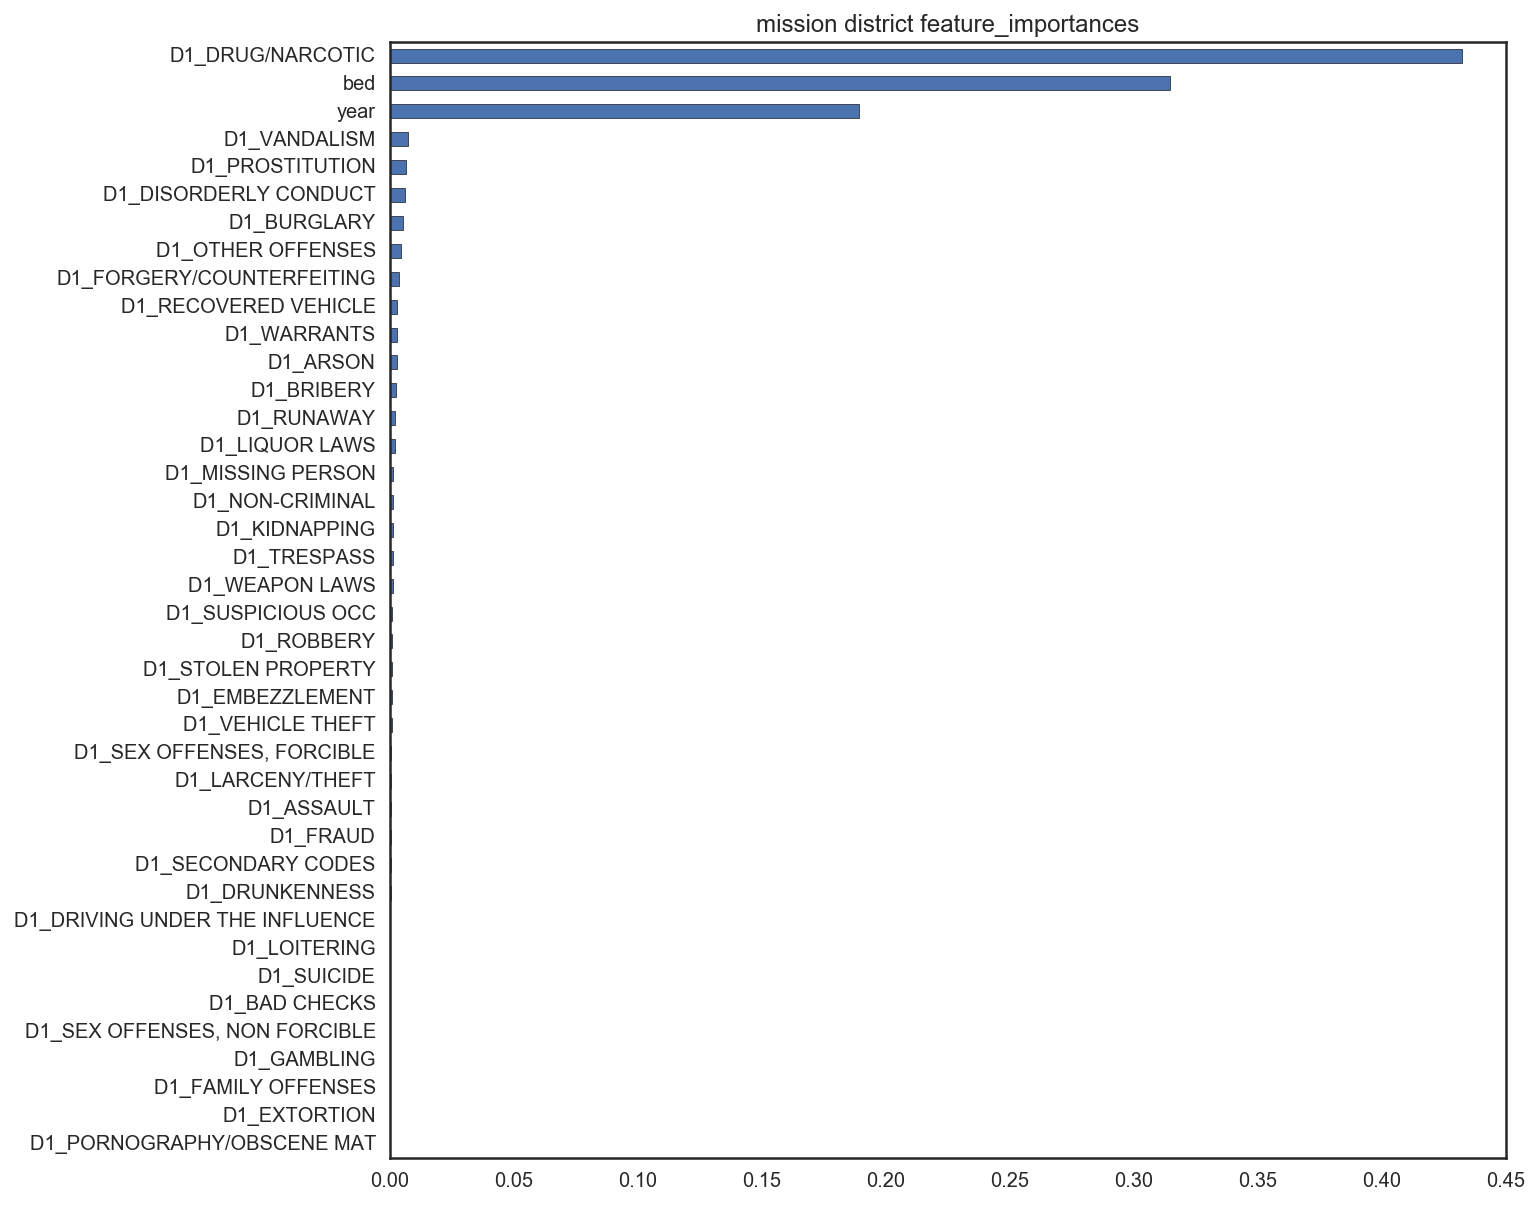

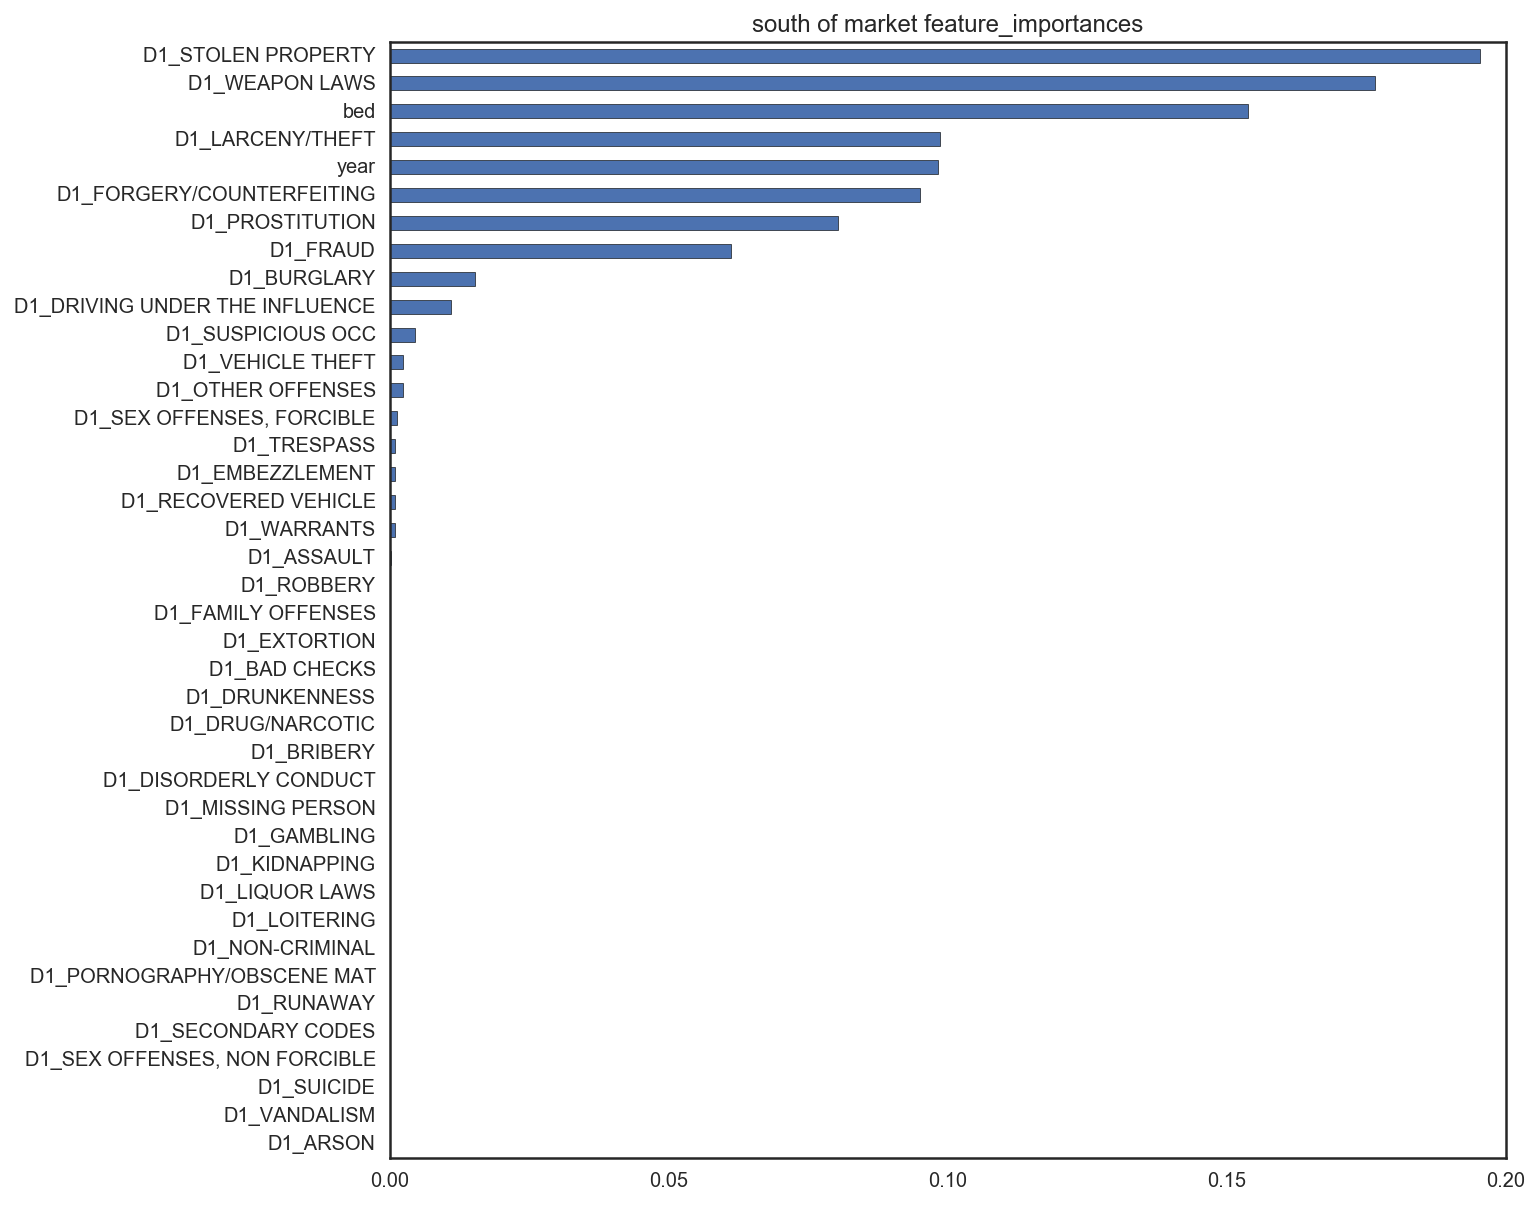

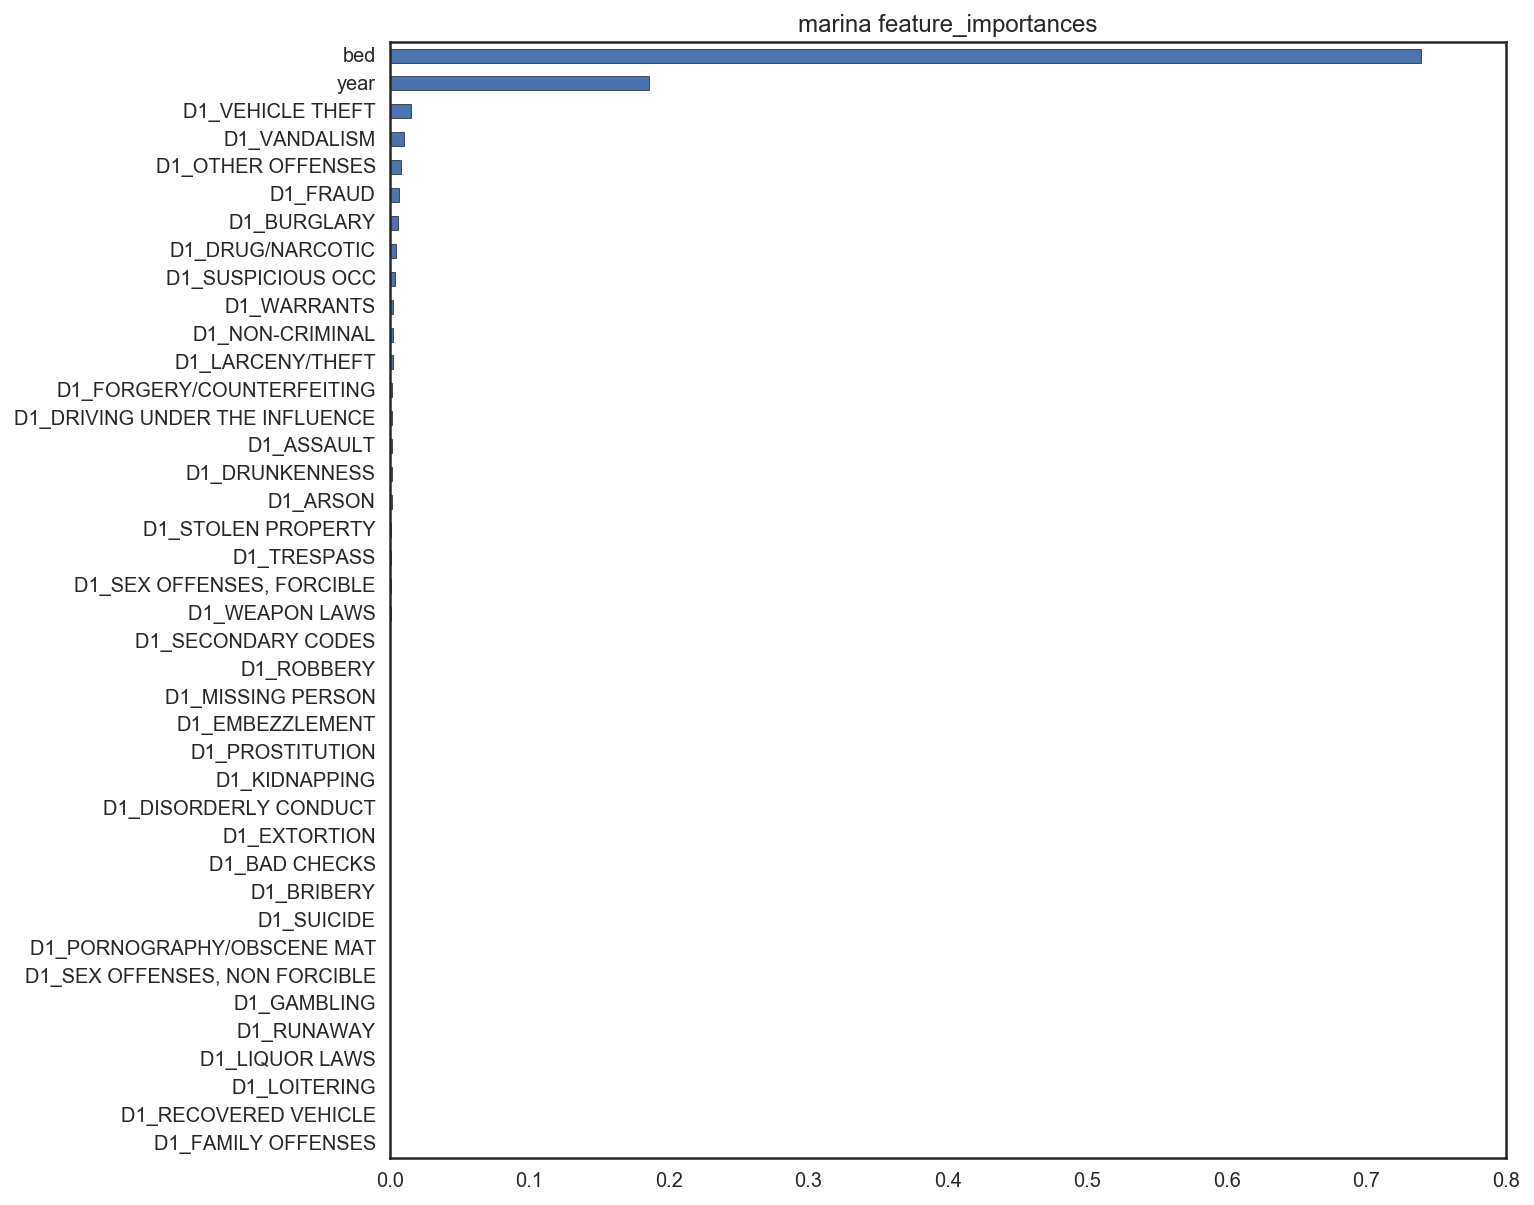

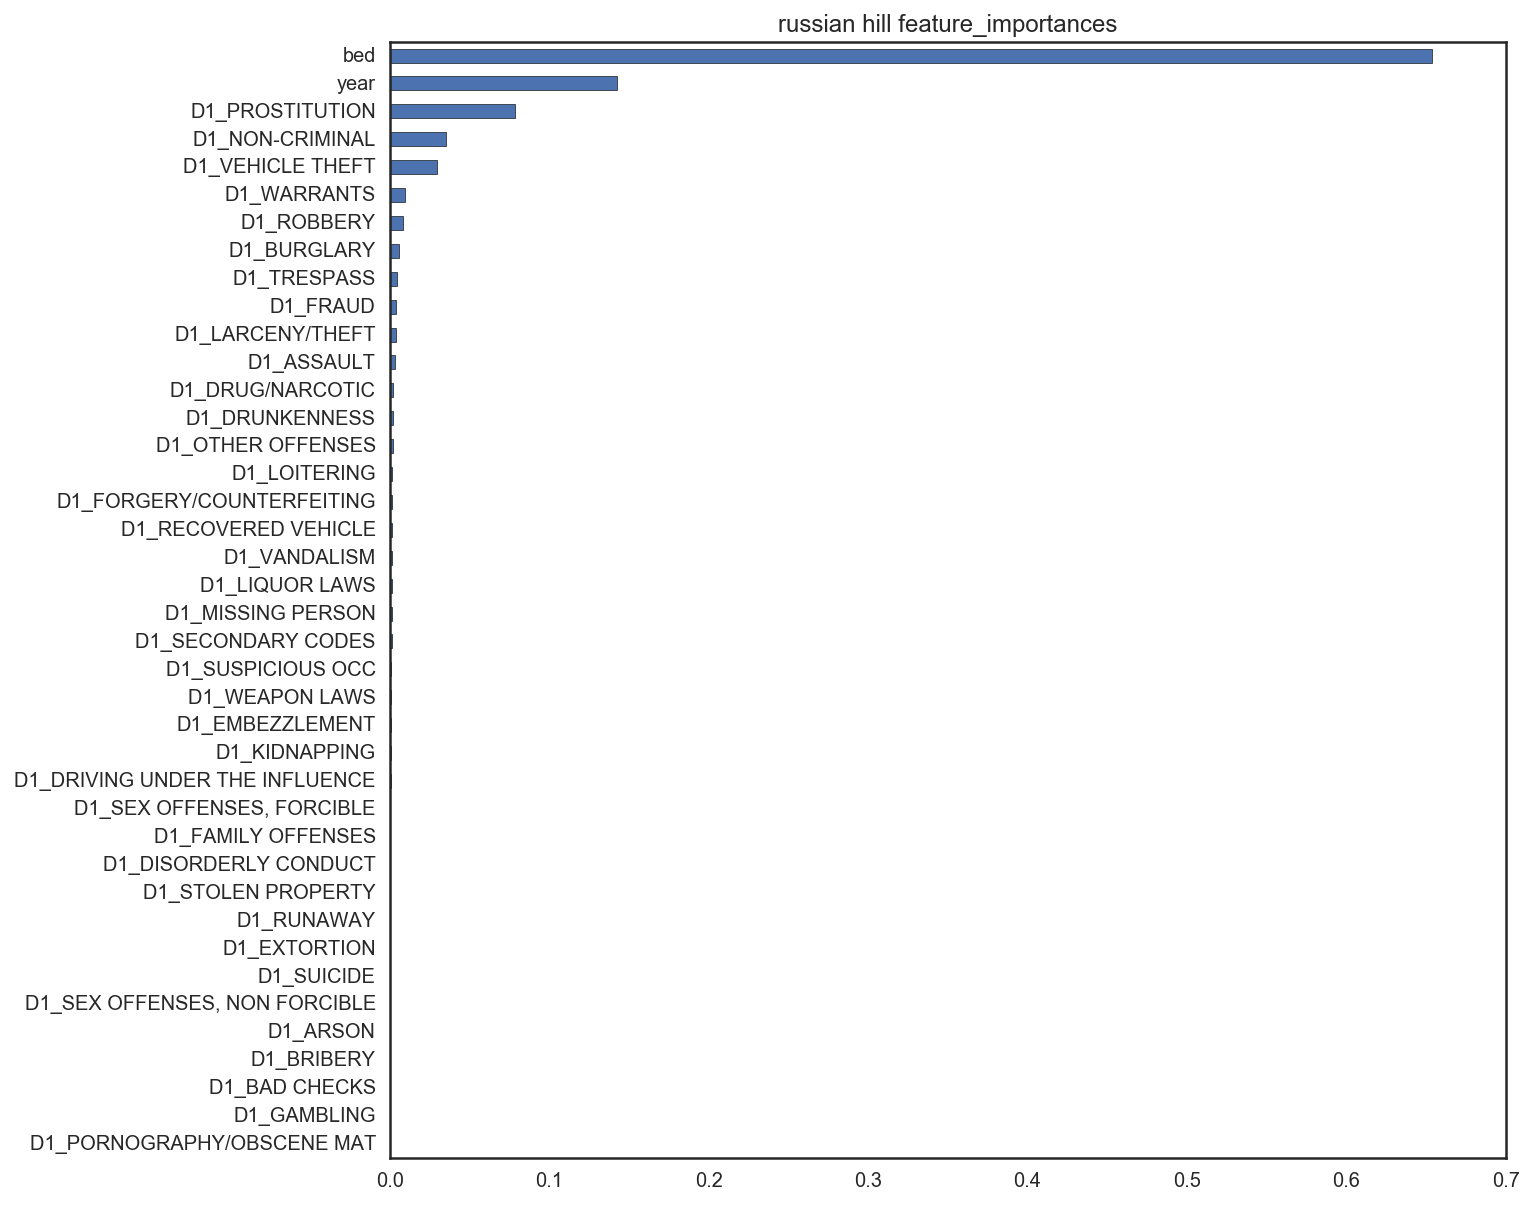

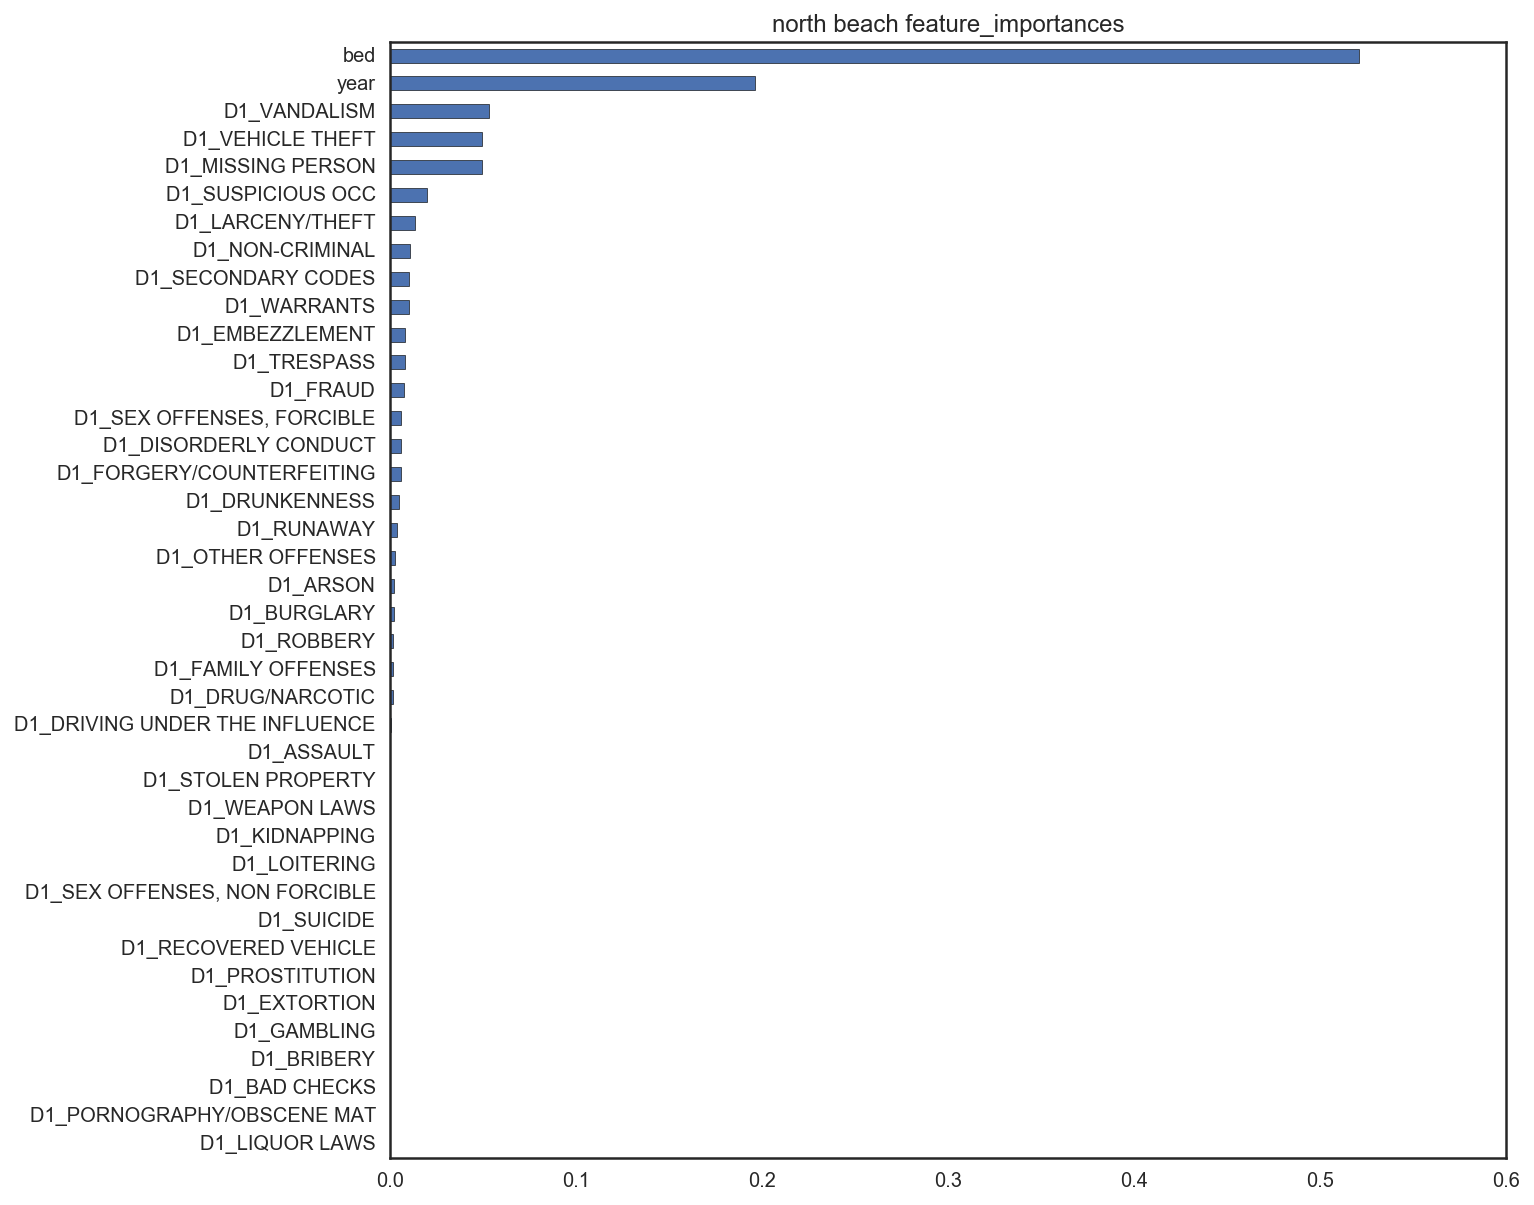

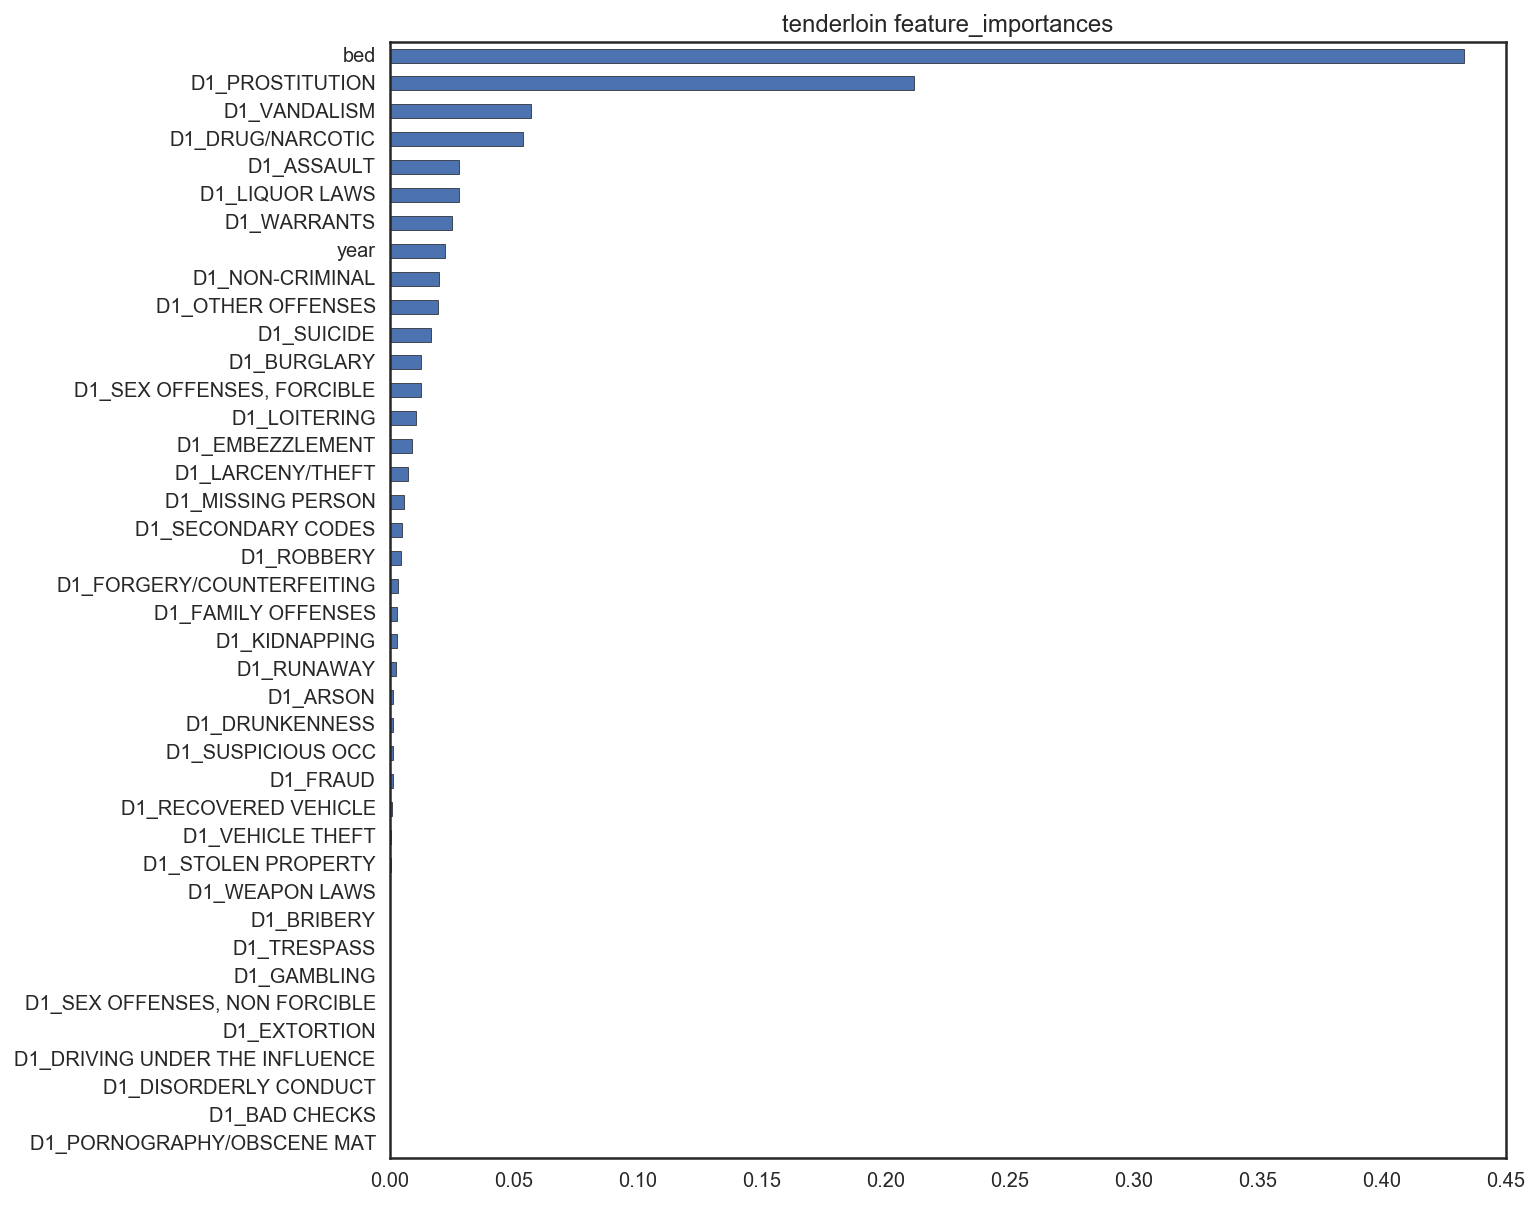

In [130]:
for index,i in enumerate(['mission district','south of market','marina','russian hill','north beach','tenderloin']):
    plt.figure(index)
    features_df_sub = features_df[i].sort_values()
    sns.set_style('white')
    features_df_sub.plot(kind = 'barh',title = i +' feature_importances')
    print i

## Mapping:

In [86]:
map_choro = pd.read_csv('/Users/Stav/Downloads/new_geoms_2.csv')

from branca.colormap import linear

colormap = linear.YlOrRd.scale(
    1000,3500)
    #map_choro.price.max())

price_dict = {}
for k,v in zip(map_choro['district1'],map_choro['price']):
    price_dict[k] = v
    
color_dict = {key: colormap(price_dict[key]) for key in price_dict.keys()}
color_dict

{'bayview': '#fec863',
 'bernal heights': '#fea747',
 'castro/upper market': '#feb54f',
 'chinatown': '#ffe98e',
 'diamond heights': '#e9251f',
 'downtown/civic center': '#feb650',
 'excelsior': '#fff6a4',
 'financial district': '#b20026',
 'glen park': '#fe9640',
 'golden gate park': '#feae4a',
 'haight ashbury': '#feb852',
 'inner richmond': '#fec15b',
 'inner sunset': '#b10026',
 'lakeshore': '#fe923e',
 'marina': '#fe9a42',
 'mission district': '#fea847',
 'nob hill': '#feb54f',
 'noe valley': '#fe943f',
 'north beach': '#fd853a',
 'ocean view': '#fea345',
 'outer mission': '#fec35e',
 'outer richmond': '#fed673',
 'outer sunset': '#febf59',
 'pacific heights': '#fd582d',
 'parkside': '#cf0f20',
 'potrero hill': '#fd6831',
 'presidio': '#fd7635',
 'presidio heights': '#f13723',
 'russian hill': '#fd7e37',
 'seacliff': '#fec35e',
 'south of market': '#b10026',
 'twin peaks': '#fea245',
 'visitacion valley': '#fd7f38',
 'west of twin peaks': '#febf59',
 'western addition': '#ffdb79'}

### Conclusions:
Different feature importances show that neighborhoods attributes such as crime counts of different types affect pricing differently.
From my analysis we can say that crime is not directly related to pricing but yet pricing might affect which types of crimes take place where.



In [89]:

from IPython.display import HTML
HTML('<iframe width="100%" height="520" frameborder="0" src="https://stavgrossfeld.cartodb.com/viz/f411c652-3cdf-11e6-8073-0ecfd53eb7d3/embed_map" \
     allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')
from folium.map import Popup, Icon, Marker
import folium
from folium import plugins

crime_sub_map = crime_sub
crime_sub_map['Date'] = crime_sub.index

#Cartodb Dark_matter
m = folium.Map(location=[37.7599,-122.431297],tiles='Cartodb Dark_matter', zoom_start = 12, min_zoom = 12, max_zoom = 15)

folium.GeoJson(open('/Users/Stav/Downloads/new_geoms_2.geojson'),style_function=lambda feature:{'fillColor': color_dict[feature['properties']['district1']],'fillOpacity':'.5','color' : 'white','weight':'3','dashArray':'5,5'}).add_to(m)

marker_cluster = folium.MarkerCluster("Theft").add_to(m)

for each in crime_sub_map[crime_sub_map['is_theft']==1][0:1000].iterrows():
    #print each[1]['Category'], each[1]['DayOfWeek'], each['Time']
    popup = str('crime: ' + each[1]['Category'] + '\n' + 'date: ' + str(each[1]['Date']).split()[0] + '\n'  'day: '  + each[1]['DayOfWeek'] + '\n' + 'time: ' + each[1]['Time'])
    folium.Marker(location = [each[1]['Y'],each[1]['X']],popup=popup).add_to(marker_cluster)
    
    
    
    

print colormap
m
# display(HTML("""
# <div style="position: absolute">
#     <div id='legend-form'>
#         <h4>rental price</h4>
#            <select name="something">
#                <option>price</option>
#                <option>crime</option>
#            </select>
#     </div>
# </div>
# """))





In [91]:
colormap

In [157]:
posts_crimes.head()

D1_ARSON  D1_ASSAULT  D1_BAD CHECKS  D1_BRIBERY  D1_BURGLARY  \
0         0           9              0           0            4   
1         0           7              0           0            5   
2         1          37              1           0           10   
3         1          16              0           0           12   
4         1          12              0           0            6   

   D1_DISORDERLY CONDUCT  D1_DRIVING UNDER THE INFLUENCE  D1_DRUG/NARCOTIC  \
0                      1                               0                 1   
1                      0                               1                 1   
2                      4                               1                34   
3                      2                               0                 3   
4                      0                               0                 4   

   D1_DRUNKENNESS  D1_EMBEZZLEMENT       ...        bed        district1  \
0               0                1       ...          1           sunset   
1               2                0       ...          2           marina   
2               1                2       ...          2     hayes valley   
3               1                0       ...          0  pacific heights   
4               1                0       ...          1   inner richmond   

          district2          district3  \
0          parkside       inner sunset   
1          nob hill           nob hill   
2        noe valley  visitacion valley   
3  presidio heights     inner richmond   
4    outer richmond       inner sunset   

                                                post   price  year  \
0  950  1br  sunny one bedroom for rent sunset  p...   950.0  2003   
1  1500  2br  1 ba cow hollow open house thursday...  1500.0  2003   
2  1795  2br  spacious  completely remodeled 2 bd...  1795.0  2003   
3  1180  0br  victorian hotel room wprivate bath ...  1180.0  2003   
4  1100  1br  great landlordgreat tenats inner ri...  1100.0  2003   

   district1_code  district2_code  district3_code  
0              45              36              14  
1              21              27              27  
2              11              28              51  
3              33              40              13  
4              13              32              14  

[5 rows x 124 columns]

In [116]:

from folium.map import Popup, Icon, Marker
import folium
from folium import plugins

from IPython.display import clear_output
from ipywidgets import *
from IPython.display import display



hello = [i for i in crime_sub.Category.unique()]


from ipywidgets import Dropdown


crime = Dropdown(
   options= hello,
   value = hello[0],
   description='Crimes: ',
)



submit_button = Button(description="Submit Info")
submit_button.on_click(test)  # test is my mapping function

display(crime)
display(submit_button)

def test(crime_sub):
    clear_output()
    print crime.value
    crime_select = crime_sub_map[crime_sub_map.Category == crime.value]
    
    select_map = folium.Map(location=[37.7599,-122.431297],tiles='Cartodb Dark_matter', zoom_start = 12, min_zoom = 12, max_zoom = 15)

    folium.GeoJson(open('/Users/Stav/Downloads/new_geoms_2.geojson'),style_function=lambda feature:{'fillColor': color_dict[feature['properties']['district1']],'fillOpacity':'.5','color' : 'white','weight':'3','dashArray':'5,5'}).add_to(select_map)

    marker_cluster = folium.MarkerCluster("select").add_to(select_map)

    for each in crime_select[0:1000].iterrows():
        #print each[1]['Category'], each[1]['DayOfWeek'], each['Time']
        popup = str('crime: ' + each[1]['Category'] + '\n' + 'date: ' + str(each[1]['Date']).split()[0] + '\n'  'day: '  + each[1]['DayOfWeek'] + '\n' + 'time: ' + each[1]['Time'])
        folium.Marker(location = [each[1]['Y'],each[1]['X']],popup=popup).add_to(marker_cluster)
    clear_output()
    display(select_map)
    display(colormap)


    clear_output
# after they submit destination.values